In [1]:
# --- Cell 1: Load inputs & build core lookup structures ---

from pathlib import Path
import json
import pickle
from collections import OrderedDict
import pandas as pd

# ---- Base path ----
BASE_PATH = Path("/users/eleves-a/2024/baptiste.geisenberger/FedScale")

# ---- Paths ----
OPENIMG_MAPPING_DIR = BASE_PATH / "benchmark/dataset/data/openImg_client_data_mapping_og"
OPENIMG_MAPPING_CSV = OPENIMG_MAPPING_DIR / "train.csv"
CLIENTS_PKL_PATH    = BASE_PATH / "benchmark/dataset/data/clients.pkl"
CLUSTERS_JSON_PATH  = BASE_PATH / "thirdparty/bliss/clusters.json"

# ---- Sanity checks on files ----
for p in [OPENIMG_MAPPING_CSV, CLIENTS_PKL_PATH, CLUSTERS_JSON_PATH]:
    if not p.exists():
        raise FileNotFoundError(f"Expected file not found: {p.resolve()}")

# ---- Load FedScale's original OpenImg mapping ----
openimg_df = pd.read_csv(
    OPENIMG_MAPPING_CSV,
    usecols=["client_id", "sample_path", "label_name", "label_id"],
    dtype={"client_id": "string", "sample_path": "string", "label_name": "string", "label_id": "Int64"},
    low_memory=False
)

# Keep handy basic aggregates (will be useful next cells)
FED_CLIENT_IDS = openimg_df["client_id"].unique().tolist()
NUM_FED_CLIENTS = len(FED_CLIENT_IDS)
NUM_LABELS = openimg_df["label_id"].nunique(dropna=True)

# ---- Load device clients database (12640 clients) ----
with open(CLIENTS_PKL_PATH, "rb") as f:
    clients_raw = pickle.load(f)

def _iter_client_entries(obj):
    """
    Yield (device_id:str, model:str|None, raw:dict) for each client entry found in the pickled structure.
    The pickle is an OrderedDict mapping -> dicts; we handle a few reasonable shapes robustly.
    """
    if isinstance(obj, (list, tuple)):
        iterable = enumerate(obj)
    elif isinstance(obj, (dict, OrderedDict)):
        iterable = obj.items()
    else:
        raise TypeError(f"Unsupported clients.pkl top-level type: {type(obj)}")

    for k, v in iterable:
        if isinstance(v, dict):
            # Prefer explicit 'id' and 'model'
            device_id = v.get("id", k)
            model = v.get("model", None)
            yield str(device_id), (None if model is None else str(model)), v
        else:
            # Fallback: treat key as id, unknown model
            yield str(k), None, {"_raw": v}

clients_list = []
for device_id, model, v in _iter_client_entries(clients_raw):
    clients_list.append({"device_id": device_id, "model": model})

devices_df = pd.DataFrame(clients_list).astype({"device_id": "string"})
# (We only need 'device_id' and 'model' now; other features remain accessible in clients_raw if needed.)

# ---- Load clusters and build model -> rank lookup ----
with open(CLUSTERS_JSON_PATH, "r", encoding="utf-8") as f:
    clusters = json.load(f)

# clusters is a list of objects: { "models": [...], "rank": int }
# Build both ways: model_to_rank and rank_to_models
model_to_rank = {}
rank_to_models = {}

for obj in clusters:
    rank = obj.get("rank", None)
    models = obj.get("models", []) or []
    if rank is None:
        continue
    rank_to_models.setdefault(rank, set())
    for m in models:
        if m in model_to_rank and model_to_rank[m] != rank:
            # If any model appears in multiple ranks, keep the first and warn in a comment-like note
            # (We don't raise here to stay robust; you can tighten if needed.)
            pass
        else:
            model_to_rank[m] = rank
            rank_to_models[rank].add(m)

# Convert rank_to_models sets to frozenset for immutability/readability (optional)
rank_to_models = {r: frozenset(ms) for r, ms in rank_to_models.items()}

# ---- Attach ranks to device clients ----
devices_df["rank"] = devices_df["model"].map(model_to_rank)

# ---- Quick summaries ----
print("=== Loaded OpenImage mapping (FedScale original) ===")
print(f"Rows (sample->client mappings): {len(openimg_df):,}")
print(f"Unique FedScale clients:        {NUM_FED_CLIENTS:,}")
print(f"Unique labels:                  {NUM_LABELS:,}")
print(openimg_df.head(3))

print("\n=== Loaded device clients (system side) ===")
print(f"Device clients total:           {len(devices_df):,}")
mapped = devices_df["rank"].notna().sum()
print(f"Devices with resolved rank:     {mapped:,} ({mapped/len(devices_df):.1%})")
print(devices_df.head(3))

print("\n=== Rank catalog ===")
all_ranks = sorted(rank_to_models.keys())
print(f"Ranks discovered: {all_ranks[:10]}{'...' if len(all_ranks) > 10 else ''} (total {len(all_ranks)})")

# ---- Expose the core variables for later cells ----
# - openimg_df: DataFrame of FedScale mapping (client_id, sample_path, label_name, label_id)
# - devices_df: DataFrame of device clients with columns ['device_id', 'model', 'rank']
# - model_to_rank: dict mapping model string -> rank int
# - rank_to_models: dict mapping rank int -> frozenset({model strings})
# - FED_CLIENT_IDS, NUM_FED_CLIENTS, NUM_LABELS: handy aggregates

=== Loaded OpenImage mapping (FedScale original) ===
Rows (sample->client mappings): 1,229,351
Unique FedScale clients:        11,325
Unique labels:                  595
  client_id                     sample_path label_name  label_id
0         0  1ea021de60b3cd89___m_09j2d.jpg   _m_09j2d         1
1         0  cae40be4017c90fd___m_09j2d.jpg   _m_09j2d         1
2         0  fd30ab5d0338b876___m_09j2d.jpg   _m_09j2d         1

=== Loaded device clients (system side) ===
Device clients total:           12,641
Devices with resolved rank:     12,641 (100.0%)
  device_id                model  rank
0         0  Fire HDX 8.9 (2014)    11
1         1  Fire HDX 8.9 (2014)    11
2         2                Le S3    11

=== Rank catalog ===
Ranks discovered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]... (total 27)


In [2]:
# --- Cell 2: Build per-client features (TF–IDF+SVD embedding + scalar stats) ---

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize

# ---------------- Config ----------------
SVD_DIM = 64

# Relative weights for appended scalars (after standardization)
WEIGHT_EMBED     = 1.0   # block weight for the SVD embedding
WEIGHT_LOGN      = 0.4
WEIGHT_ENTROPY   = 0.4
WEIGHT_DOMINANCE = 0.2
WEIGHT_TAILNESS  = 0.3

# ------------- Build counts matrix X (clients x labels) -------------
_openimg = openimg_df.dropna(subset=["label_id"]).copy()
_openimg["label_id"] = _openimg["label_id"].astype(int)

client_ids = FED_CLIENT_IDS  # from Cell 1
n_clients = len(client_ids)

label_ids = np.sort(_openimg["label_id"].unique())
n_labels = len(label_ids)

client_id_to_row = {cid: i for i, cid in enumerate(client_ids)}
label_id_to_col  = {lid: j for j, lid in enumerate(label_ids)}

cnt_df = (
    _openimg
    .groupby(["client_id", "label_id"], observed=True)
    .size()
    .rename("count")
    .reset_index()
)
row_idx = cnt_df["client_id"].map(client_id_to_row).to_numpy()
col_idx = cnt_df["label_id"].map(label_id_to_col).to_numpy()
data    = cnt_df["count"].astype(np.float32).to_numpy()

X_counts = sparse.coo_matrix((data, (row_idx, col_idx)), shape=(n_clients, n_labels), dtype=np.float32).tocsr()

# ------------- Per-client scalar stats -------------
row_sums = np.asarray(X_counts.sum(axis=1)).ravel().astype(np.float64)
row_sums[row_sums == 0] = 1.0

# Probabilities
X_prob = X_counts.copy().tocsr()
indptr = X_prob.indptr
for i in range(n_clients):
    start, end = indptr[i], indptr[i+1]
    if end > start:
        X_prob.data[start:end] /= row_sums[i]

# Entropy and dominance
entropies = np.empty(n_clients, dtype=np.float64)
dominance = np.empty(n_clients, dtype=np.float64)
for i in range(n_clients):
    start, end = indptr[i], indptr[i+1]
    if end == start:
        entropies[i] = 0.0
        dominance[i] = 0.0
        continue
    p = X_prob.data[start:end]
    entropies[i] = -np.sum(p * np.log(p + 1e-12))
    dominance[i] = p.max()

# log(n)
log_n = np.log(row_sums)

# ------------- TF–IDF + SVD embedding -------------
tfidf = TfidfTransformer(norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False)
X_tfidf = tfidf.fit_transform(X_counts)

# Tailness: average IDF weighted by client label distribution
idf_vector = tfidf.idf_.astype(np.float64)             # length n_labels
tailness = np.asarray(X_prob @ idf_vector).ravel()     # FIX: remove `.A`, convert defensively

# Dimensionality reduction on TF–IDF
svd = TruncatedSVD(n_components=SVD_DIM, random_state=0)
X_embed = svd.fit_transform(X_tfidf)

# ------------- Standardize and assemble feature matrix -------------
embed_scaler = StandardScaler(with_mean=True, with_std=True)
X_embed_z = embed_scaler.fit_transform(X_embed) * WEIGHT_EMBED

scalars_df = pd.DataFrame({
    "client_id": client_ids,
    "log_n": log_n,
    "entropy": entropies,
    "dominance": dominance,
    "tailness": tailness,
})

scalar_scaler = StandardScaler(with_mean=True, with_std=True)
scalar_block = scalar_scaler.fit_transform(
    scalars_df[["log_n", "entropy", "dominance", "tailness"]].to_numpy().astype(np.float64)
)

# Apply per-feature weights
scalar_block[:, 0] *= WEIGHT_LOGN
scalar_block[:, 1] *= WEIGHT_ENTROPY
scalar_block[:, 2] *= WEIGHT_DOMINANCE
scalar_block[:, 3] *= WEIGHT_TAILNESS

# Assemble final feature matrix
X_features = np.hstack([X_embed_z, scalar_block]).astype(np.float32)

# L2-normalize rows for spherical k-means
X_norm = normalize(X_features, norm="l2", copy=True)

print("Built features:")
print(f"  clients        : {n_clients:,}")
print(f"  labels         : {n_labels:,}")
print(f"  feature dim    : {X_norm.shape[1]}")
print(f"  sample of scalars:\n{scalars_df.head(3)}")


Built features:
  clients        : 11,325
  labels         : 595
  feature dim    : 68
  sample of scalars:
  client_id     log_n   entropy  dominance  tailness
0         0  6.267201  1.675214   0.590133  2.134192
1         2  8.146419  3.250712   0.165170  1.674203
2         3  4.753590  2.737892   0.198276  2.224599


In [3]:
# --- Cell 3: Spherical k-means clustering (k=27) with manual restarts & timing ---

import numpy as np
from time import perf_counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# ------------- Config -------------
K = 27
N_RESTARTS = 20
MAX_ITER = 300
SEED_BASE = 42
TOL = 1e-4

# ------------- Clustering with restarts -------------
best = {
    "inertia": np.inf,
    "model": None,
    "labels": None,
    "centers": None,
    "seed": None,
    "elapsed": None,
}

times = []
inertias = []

print(f"Clustering {X_norm.shape[0]:,} clients, dim={X_norm.shape[1]} with spherical k-means (k={K}, restarts={N_RESTARTS})")
for r in range(N_RESTARTS):
    seed = SEED_BASE + r
    km = KMeans(
        n_clusters=K,
        n_init=1,              # manual restarts
        max_iter=MAX_ITER,
        tol=TOL,
        algorithm="lloyd",
        random_state=seed,
        verbose=0
    )
    t0 = perf_counter()
    km.fit(X_norm)            # X_norm rows are L2-normalized (spherical)
    dt = perf_counter() - t0

    # Track
    times.append(dt)
    inertias.append(km.inertia_)
    if km.inertia_ < best["inertia"]:
        best.update({
            "inertia": km.inertia_,
            "model": km,
            "labels": km.labels_.copy(),
            "centers": km.cluster_centers_.copy(),
            "seed": seed,
            "elapsed": dt,
        })

    print(f"[restart {r+1:02d}/{N_RESTARTS}] time={dt:.2f}s  inertia={km.inertia_:,.2f}  best_so_far={best['inertia']:,.2f} (seed={best['seed']})")

# Normalize centers to unit length for cosine interpretation
centers_norm = normalize(best["centers"], norm="l2", copy=True)

# Cosine similarity of each point to its assigned (normalized) center (diagnostic)
assigned_centers = centers_norm[best["labels"]]
avg_cos_sim = float(np.mean(np.einsum('ij,ij->i', X_norm, assigned_centers)))

# Cluster size summary
labels = best["labels"]
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique.tolist(), counts.tolist()))

print("\n=== Spherical k-means result (best restart) ===")
print(f"seed: {best['seed']}, time: {best['elapsed']:.2f}s, inertia: {best['inertia']:.2f}")
print(f"avg cosine similarity to assigned centroid: {avg_cos_sim:.4f}")
print("cluster sizes:", {int(k): int(v) for k, v in sorted(cluster_sizes.items(), key=lambda kv: kv[0])})
print(f"\nMean restart time: {np.mean(times):.2f}s (±{np.std(times):.2f}s)")

# Expose artifacts
kmeans_model   = best["model"]
kmeans_labels  = best["labels"]          # array shape (n_clients,)
kmeans_centers = centers_norm            # unit-length centroids for cosine
kmeans_inertia = best["inertia"]
kmeans_seed    = best["seed"]

# Per-cluster summary DataFrame with scalar stats
cluster_summary = (
    pd.DataFrame({
        "client_id": client_ids,
        "cluster": kmeans_labels,
    })
    .merge(scalars_df, on="client_id", how="left")
    .groupby("cluster")
    .agg(
        size=("client_id", "count"),
        mean_log_n=("log_n", "mean"),
        mean_entropy=("entropy", "mean"),
        mean_dominance=("dominance", "mean"),
        mean_tailness=("tailness", "mean"),
    )
    .reset_index()
    .sort_values("cluster")
)

print("\nCluster-level summary (head):")
print(cluster_summary.head(10).to_string(index=False))


Clustering 11,325 clients, dim=68 with spherical k-means (k=27, restarts=20)
[restart 01/20] time=0.13s  inertia=8,668.01  best_so_far=8,668.01 (seed=42)
[restart 02/20] time=0.03s  inertia=8,659.38  best_so_far=8,659.38 (seed=43)
[restart 03/20] time=0.04s  inertia=8,591.80  best_so_far=8,591.80 (seed=44)
[restart 04/20] time=0.04s  inertia=8,669.00  best_so_far=8,591.80 (seed=44)
[restart 05/20] time=0.04s  inertia=8,596.89  best_so_far=8,591.80 (seed=44)
[restart 06/20] time=0.03s  inertia=8,623.39  best_so_far=8,591.80 (seed=44)
[restart 07/20] time=0.03s  inertia=8,675.67  best_so_far=8,591.80 (seed=44)
[restart 08/20] time=0.03s  inertia=8,668.94  best_so_far=8,591.80 (seed=44)
[restart 09/20] time=0.03s  inertia=8,648.63  best_so_far=8,591.80 (seed=44)
[restart 10/20] time=0.04s  inertia=8,621.44  best_so_far=8,591.80 (seed=44)
[restart 11/20] time=0.03s  inertia=8,648.17  best_so_far=8,591.80 (seed=44)
[restart 12/20] time=0.03s  inertia=8,675.19  best_so_far=8,591.80 (seed=44)

In [4]:
# --- Cell 4: Two-stage clustering — M=150 micro-clusters → pack to 27 macro-clusters ---

import numpy as np
import pandas as pd
from time import perf_counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# ---------------- Config ----------------
M_MICRO = 150
K_MACRO = 27
N_RESTARTS_MICRO = 20
N_RESTARTS_MACRO = 30
MAX_ITER = 300
SEED_BASE = 123
TOL = 1e-4

# ---------------- Stage 1: Micro-clustering on client features ----------------
best_micro = {
    "inertia": np.inf,
    "model": None,
    "labels": None,
    "centers": None,
    "seed": None,
    "elapsed": None,
}

t0 = perf_counter()
for r in range(N_RESTARTS_MICRO):
    seed = SEED_BASE + r
    km = KMeans(
        n_clusters=M_MICRO,
        n_init=1,            # manual restarts
        max_iter=MAX_ITER,
        tol=TOL,
        algorithm="lloyd",
        random_state=seed,
        verbose=0
    )
    km.fit(X_norm)          # X_norm is L2-normalized (spherical k-means)
    if km.inertia_ < best_micro["inertia"]:
        best_micro.update({
            "inertia": km.inertia_,
            "model": km,
            "labels": km.labels_.copy(),
            "centers": km.cluster_centers_.copy(),
            "seed": seed,
        })
t_micro = perf_counter() - t0

micro_labels  = best_micro["labels"]                    # shape (n_clients,)
micro_centers = normalize(best_micro["centers"], copy=True)  # unit-length
micro_inertia = best_micro["inertia"]
micro_seed    = best_micro["seed"]

# Micro sizes
uniq_micro, counts_micro = np.unique(micro_labels, return_counts=True)
micro_sizes = np.zeros(M_MICRO, dtype=int)
micro_sizes[uniq_micro] = counts_micro

# ---------------- Stage 2: Pack micro-clusters into K=27 macro-clusters ----------------
# We cluster the (normalized) micro-centroids, weighting each by its size.
# If sklearn's KMeans supports sample_weight (newer versions), we use it; otherwise we gracefully fall back to unweighted.

best_macro = {
    "inertia": np.inf,
    "model": None,
    "labels": None,    # labels for the micro-centroids
    "centers": None,
    "seed": None,
}

t1 = perf_counter()
for r in range(N_RESTARTS_MACRO):
    seed = SEED_BASE*17 + r
    km_macro = KMeans(
        n_clusters=K_MACRO,
        n_init=1,
        max_iter=MAX_ITER,
        tol=TOL,
        algorithm="lloyd",
        random_state=seed,
        verbose=0
    )
    try:
        km_macro.fit(micro_centers, sample_weight=micro_sizes)
    except TypeError:
        # Fallback: no sample_weight available
        km_macro.fit(micro_centers)

    if km_macro.inertia_ < best_macro["inertia"]:
        best_macro.update({
            "inertia": km_macro.inertia_,
            "model": km_macro,
            "labels": km_macro.labels_.copy(),       # length M_MICRO
            "centers": normalize(km_macro.cluster_centers_, copy=True),
            "seed": seed,
        })
t_macro = perf_counter() - t1

micro_to_macro = best_macro["labels"]                   # map micro id -> macro id (0..K_MACRO-1)
macro_centers_microspace = best_macro["centers"]        # unit-length centers in micro-centroid space

# ---------------- Derive per-client macro labels ----------------
macro_labels = micro_to_macro[micro_labels]             # per client

# ---------------- Compute macro centers directly from client features (for diagnostics) ----------------
# Sum per cluster in feature space then L2-normalize to get spherical centroids
d = X_norm.shape[1]
macro_centers_clientspace = np.zeros((K_MACRO, d), dtype=np.float64)
for k in range(K_MACRO):
    idx = np.nonzero(macro_labels == k)[0]
    if len(idx) > 0:
        macro_centers_clientspace[k] = X_norm[idx].sum(axis=0)
# Normalize (avoid zero division)
macro_centers_clientspace = normalize(macro_centers_clientspace, copy=True)

# Average cosine similarity client→assigned macro center (clientspace)
assigned_macro_centers = macro_centers_clientspace[macro_labels]
avg_cos_sim_macro = float(np.mean(np.einsum('ij,ij->i', X_norm, assigned_macro_centers)))

# ---------------- Summaries ----------------
# Micro-cluster summary
micro_summary = (
    pd.DataFrame({
        "micro": np.arange(M_MICRO, dtype=int),
        "micro_size": micro_sizes,
        "macro": micro_to_macro
    })
    .sort_values(["macro", "micro"])
)

# Macro-cluster summary (aggregate per-client scalar stats)
macro_summary = (
    pd.DataFrame({
        "client_id": client_ids,
        "macro": macro_labels,
    })
    .merge(scalars_df, on="client_id", how="left")
    .groupby("macro")
    .agg(
        size=("client_id", "count"),
        mean_log_n=("log_n", "mean"),
        mean_entropy=("entropy", "mean"),
        mean_dominance=("dominance", "mean"),
        mean_tailness=("tailness", "mean"),
    )
    .reset_index()
    .sort_values("macro")
)

# Add how many micro-clusters were packed into each macro
micro_per_macro = micro_summary.groupby("macro")["micro"].count().rename("num_micro")
macro_summary = macro_summary.merge(micro_per_macro, on="macro", how="left")

# ---------------- Output: compact, confirmatory prints ----------------
print("=== Two-stage clustering complete ===")
print(f"Clients: {X_norm.shape[0]:,}  Dim: {X_norm.shape[1]}")
print(f"Micro: k={M_MICRO}, restarts={N_RESTARTS_MICRO}, best_inertia={micro_inertia:,.2f}, time={t_micro:.2f}s, seed={micro_seed}")
print(f"Macro: k={K_MACRO}, restarts={N_RESTARTS_MACRO}, best_inertia={best_macro['inertia']:,.2f}, time={t_macro:.2f}s, avg cos(sim to macro center)={avg_cos_sim_macro:.4f}")

print("\nMacro cluster sizes (clients) and packed micro counts:")
print(macro_summary[["macro", "size", "num_micro"]].to_string(index=False))

print("\nMacro-level statistics (head):")
print(macro_summary[["macro", "mean_log_n", "mean_entropy", "mean_dominance", "mean_tailness"]].head(10).to_string(index=False))

# ---------------- Expose artifacts ----------------
# Micro level
micro_kmeans_model   = best_micro["model"]
micro_labels_client  = micro_labels          # per-client micro assignment
micro_centers_unit   = micro_centers         # unit-length micro centers
micro_sizes_vec      = micro_sizes           # size of each micro cluster

# Macro level
macro_kmeans_model   = best_macro["model"]   # micro-centroid space model
micro_to_macro_map   = micro_to_macro        # array length M_MICRO
macro_labels_client  = macro_labels          # per-client macro assignment (0..K_MACRO-1)
macro_centers_unit   = macro_centers_clientspace  # unit-length centers in client feature space
macro_summary_df     = macro_summary         # DataFrame summary

# Mapping DataFrame (client_id, micro, macro)
client_cluster_map = pd.DataFrame({
    "client_id": client_ids,
    "micro": micro_labels_client,
    "macro": macro_labels_client
})


=== Two-stage clustering complete ===
Clients: 11,325  Dim: 68
Micro: k=150, restarts=20, best_inertia=6,397.23, time=2.92s, seed=141
Macro: k=27, restarts=30, best_inertia=6,352.27, time=0.08s, avg cos(sim to macro center)=0.4152

Macro cluster sizes (clients) and packed micro counts:
 macro  size  num_micro
     0   341          5
     1   278          5
     2   326          4
     3   509          8
     4   507          7
     5   396          6
     6   241          3
     7   352          4
     8   360          6
     9   719          9
    10   235          3
    11   344          5
    12   266          4
    13   225          2
    14   269          3
    15   447          5
    16   222          3
    17   193          3
    18   965         11
    19   700         10
    20   190          2
    21   168          1
    22   436          7
    23   291          4
    24   542          8
    25   397          5
    26  1406         17

Macro-level statistics (head):
 macro  m

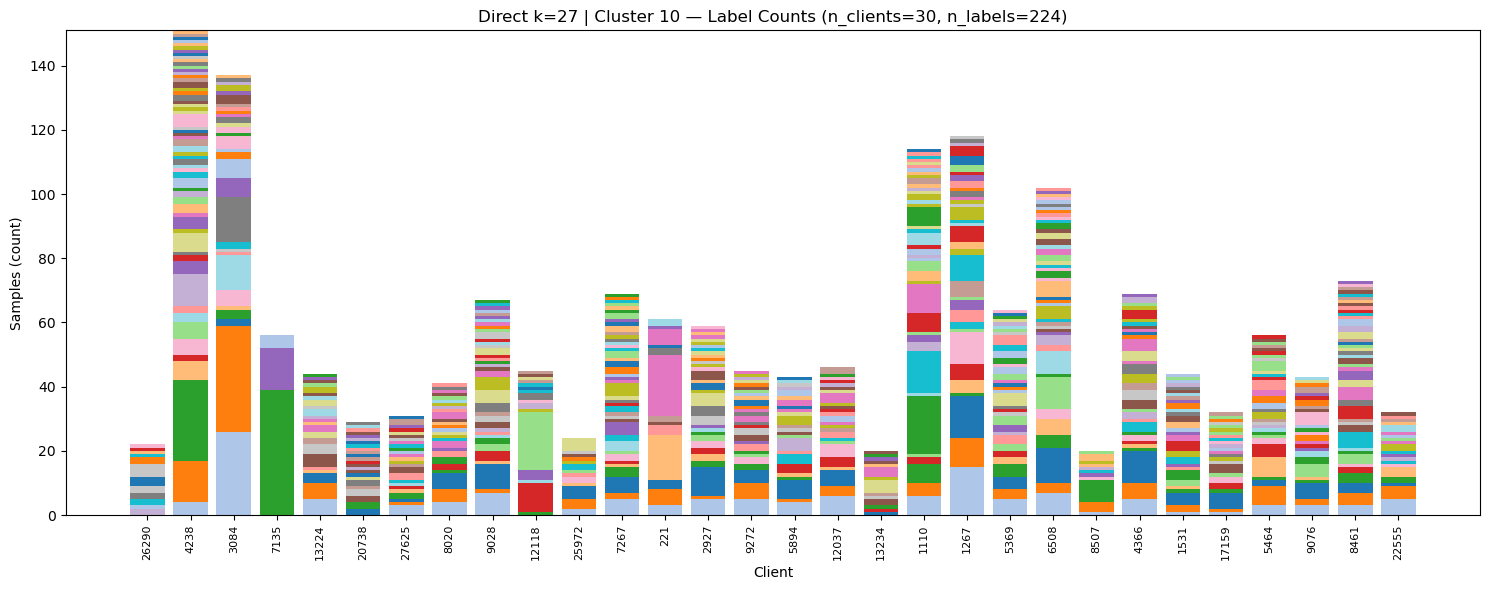

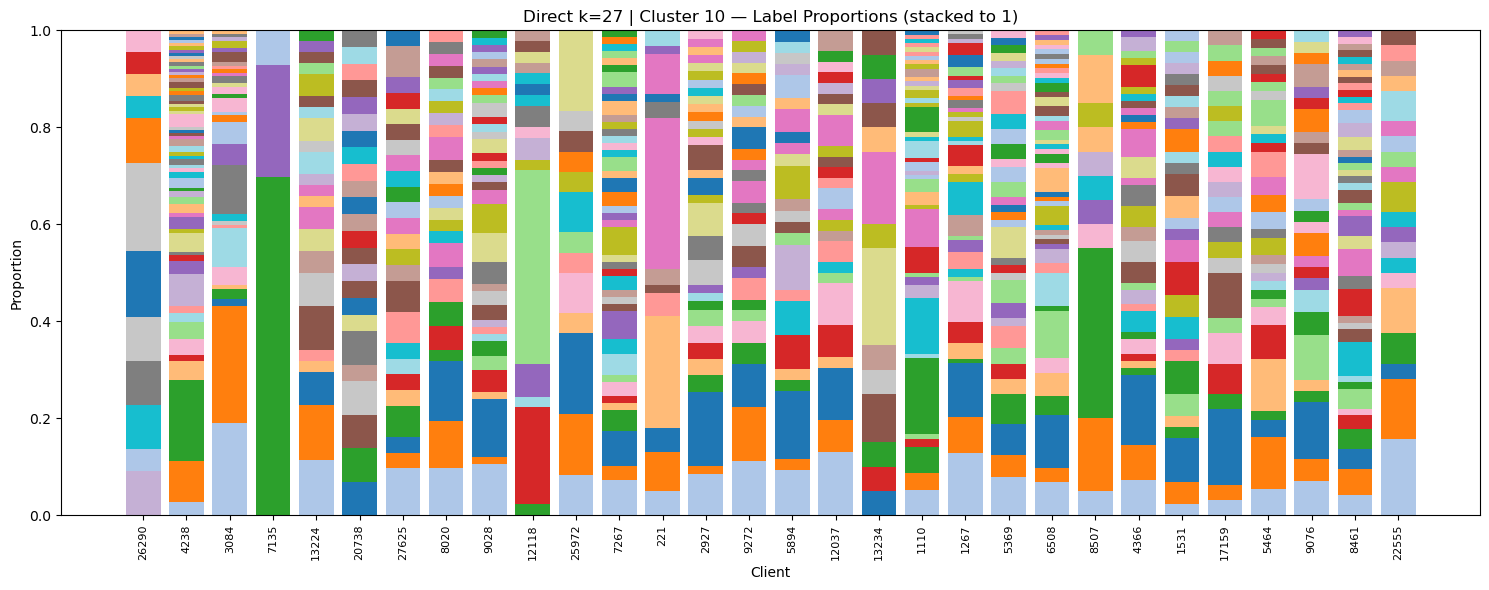

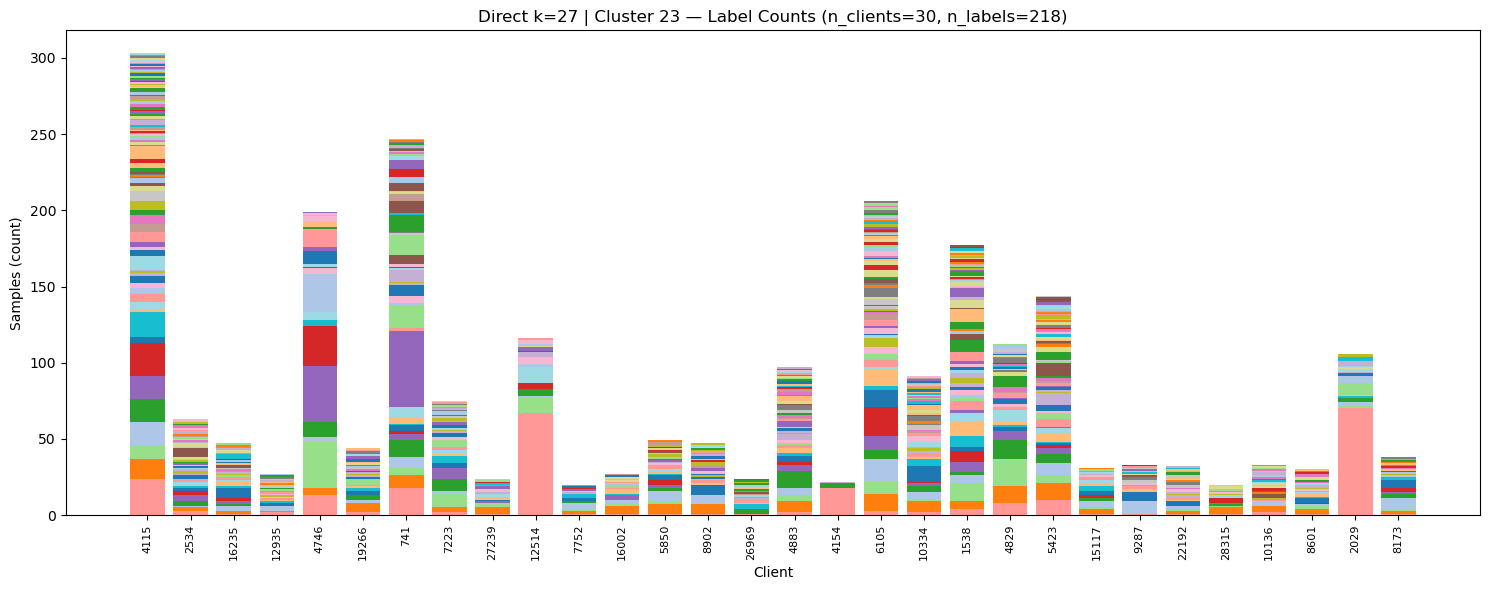

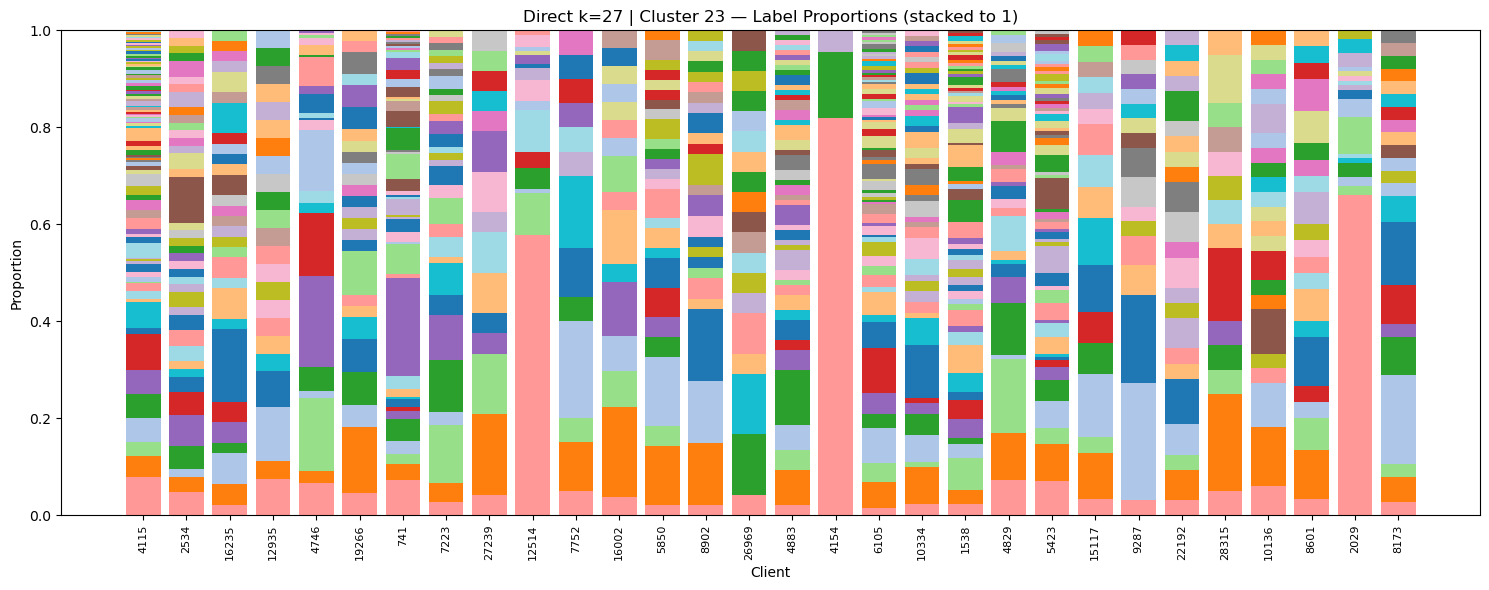

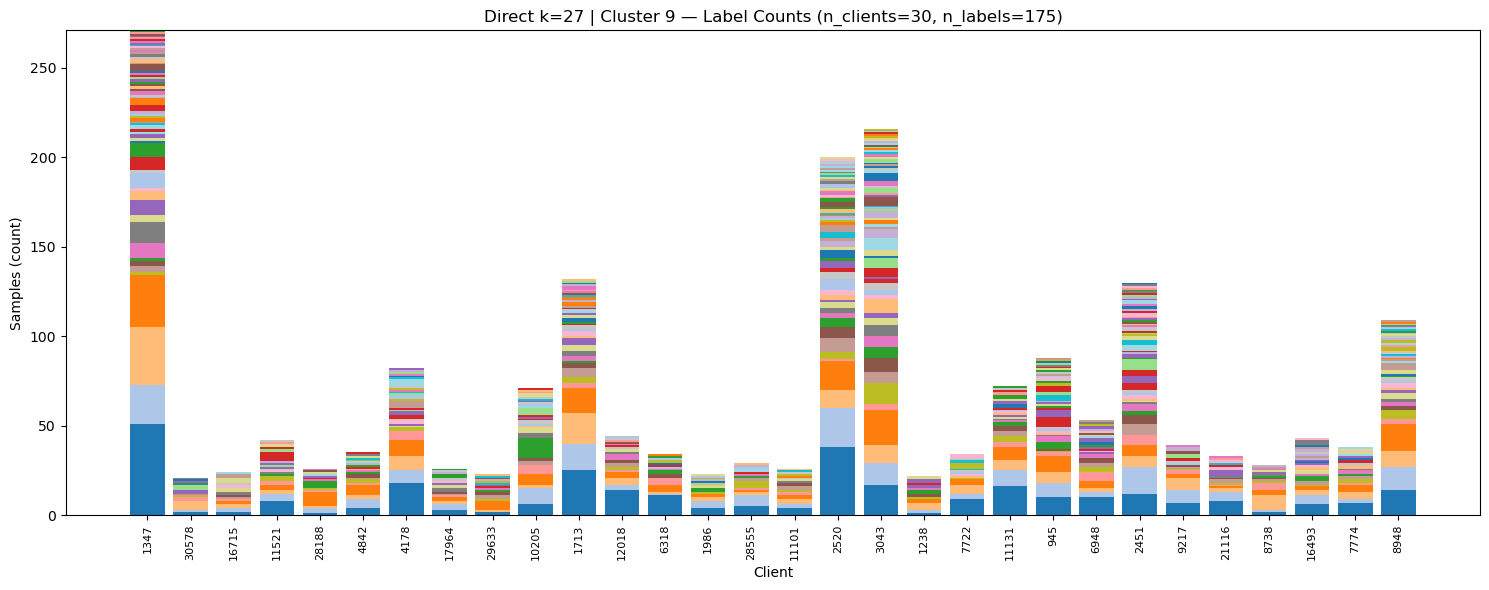

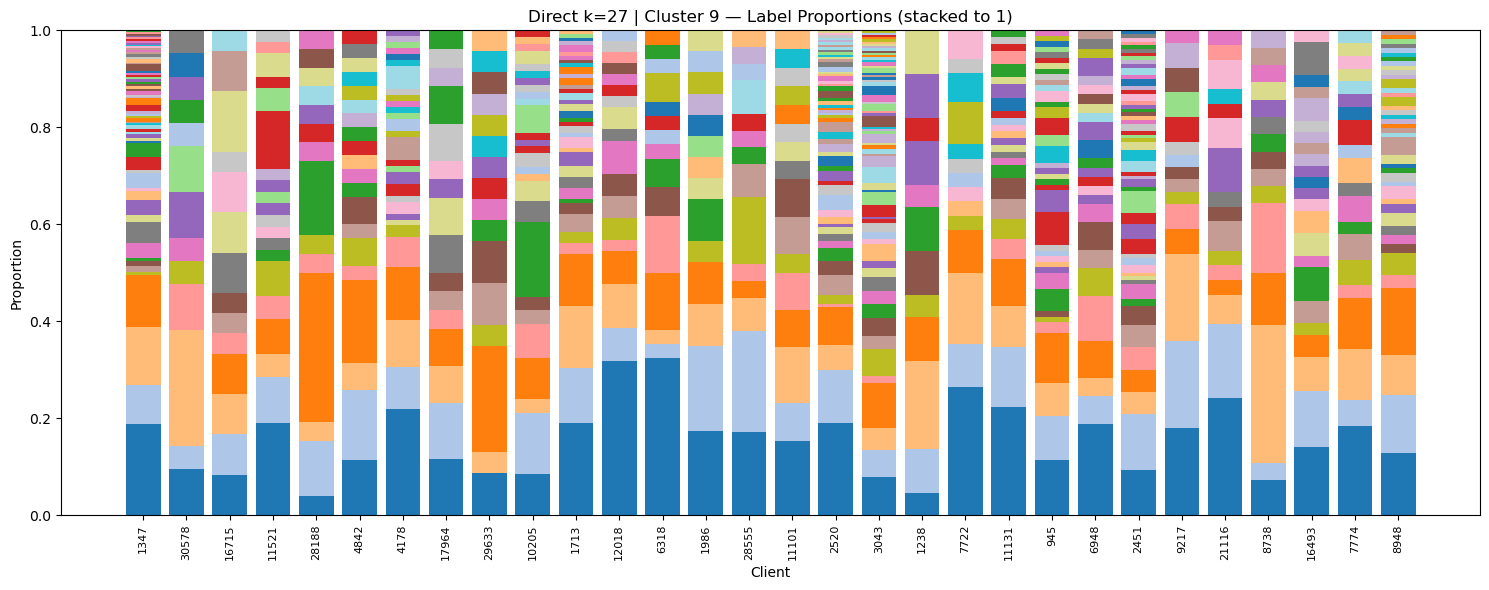

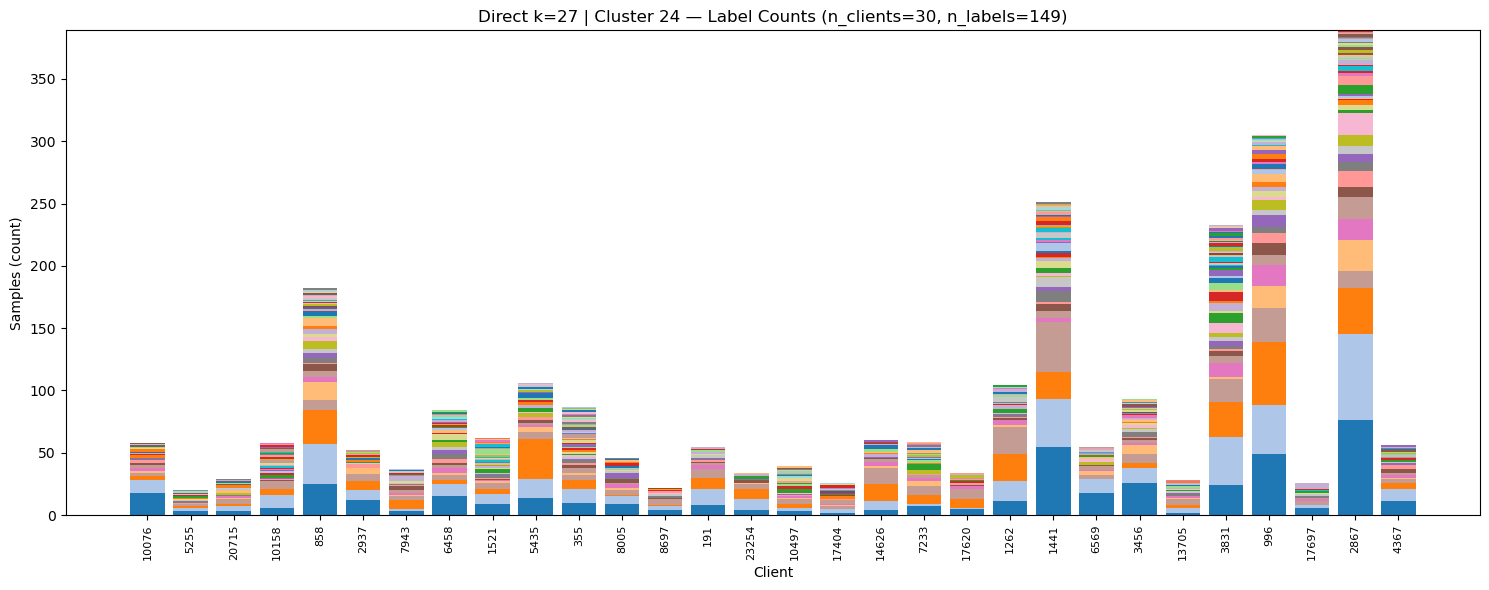

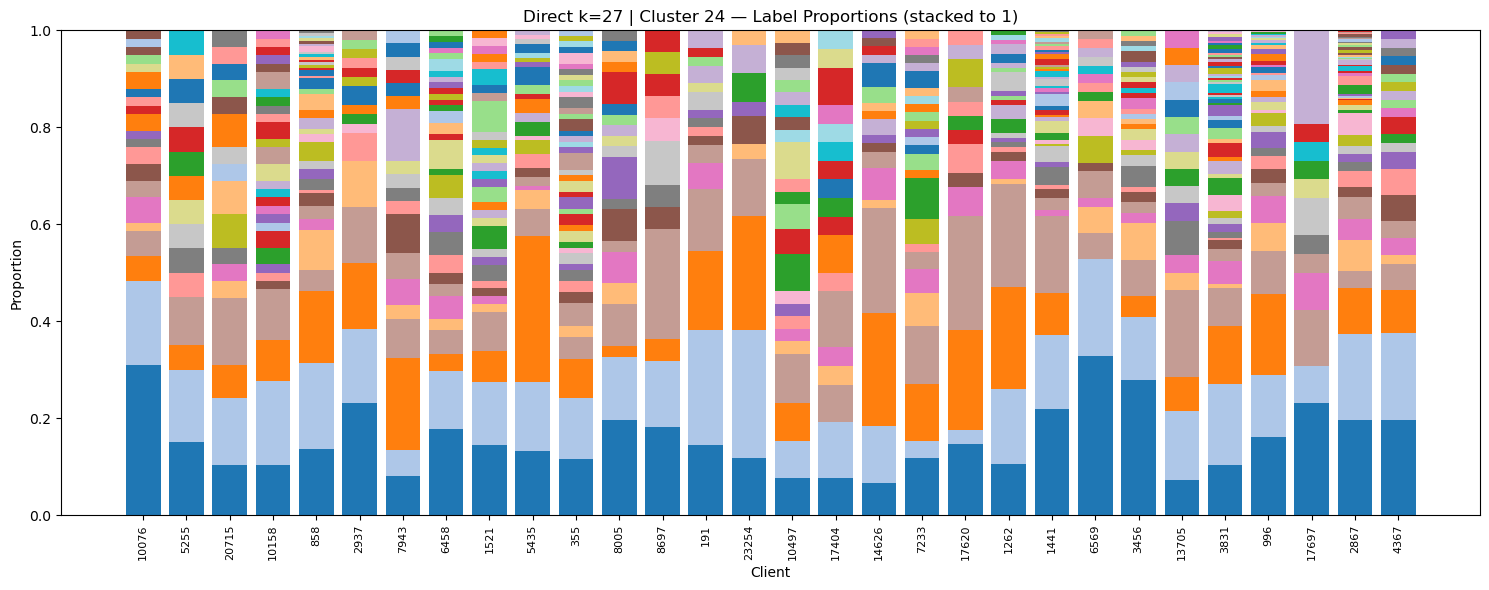

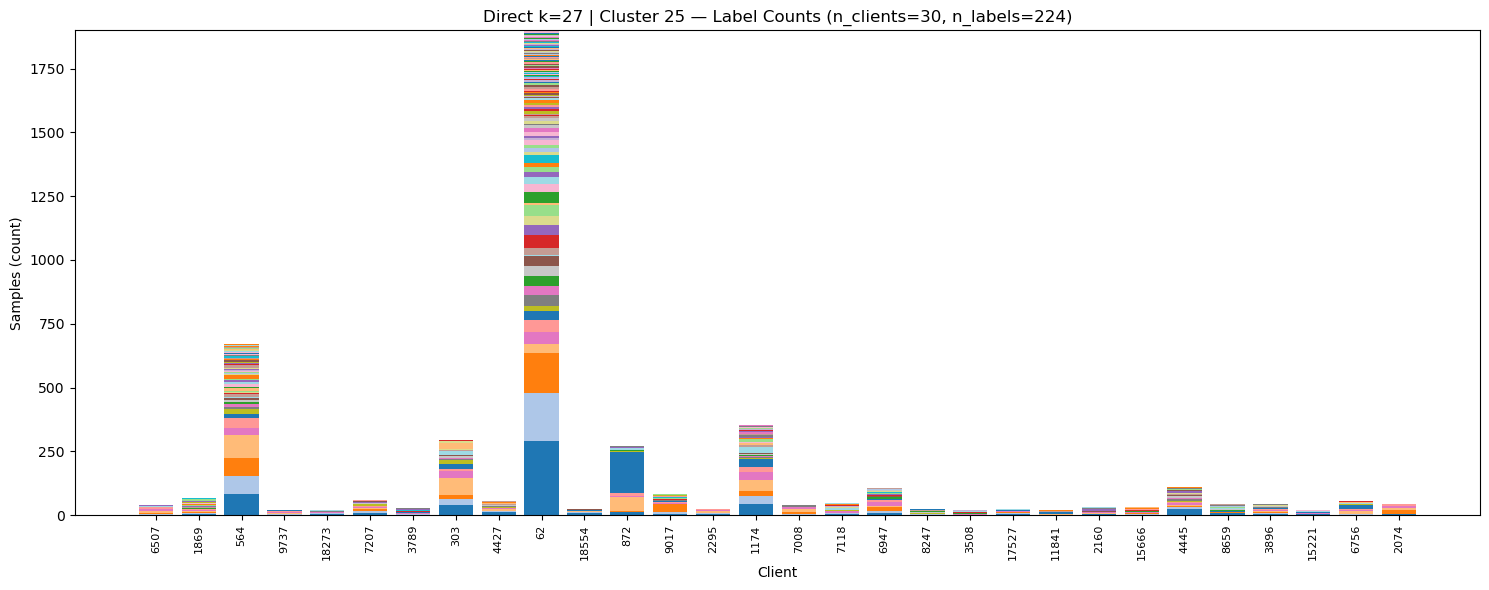

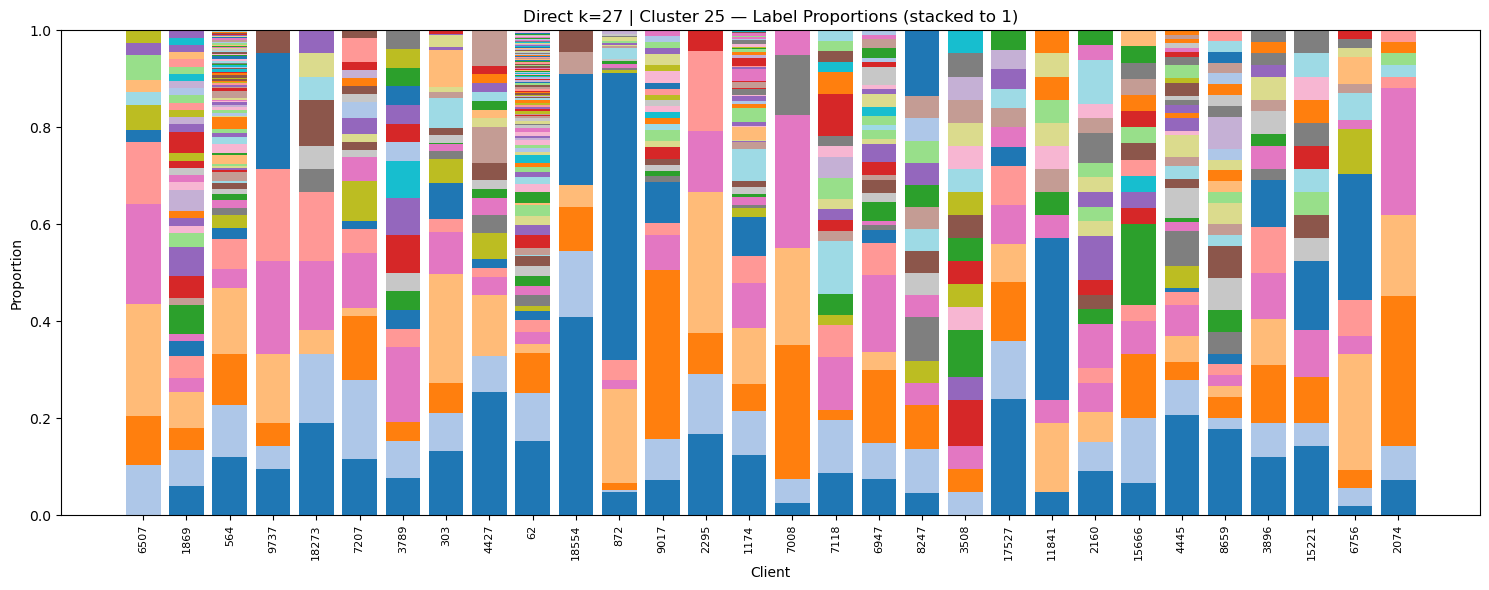

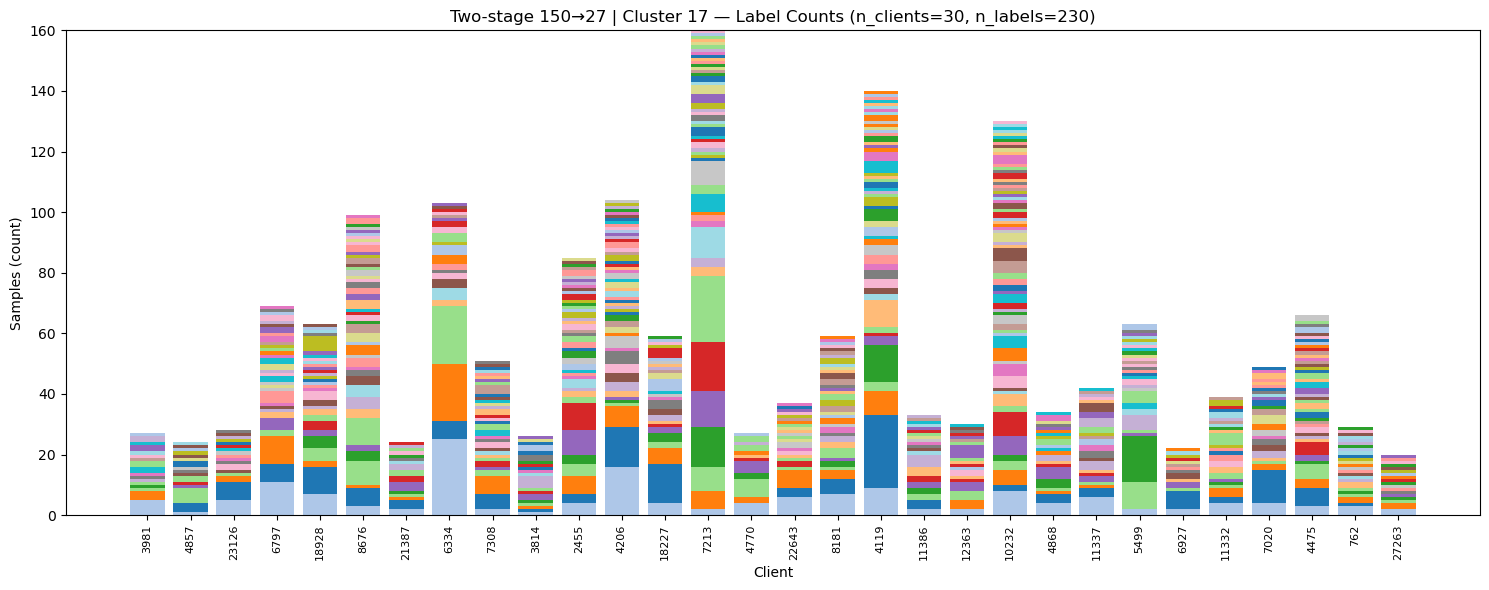

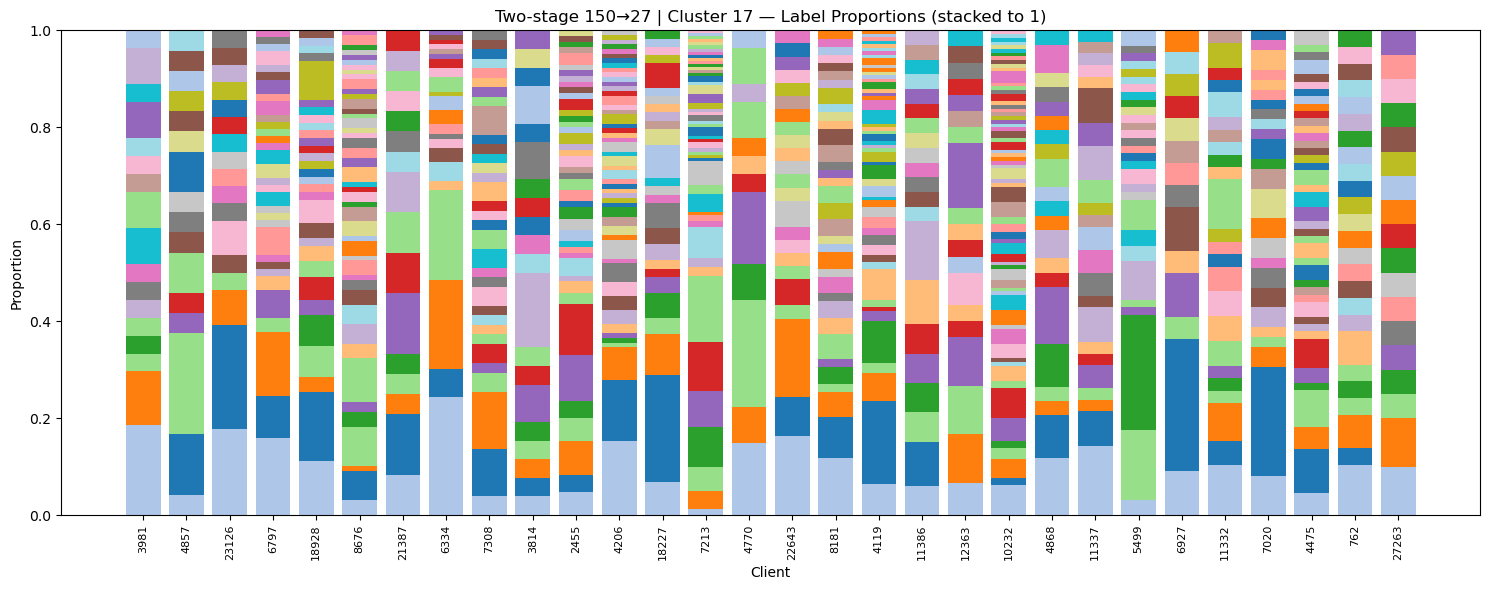

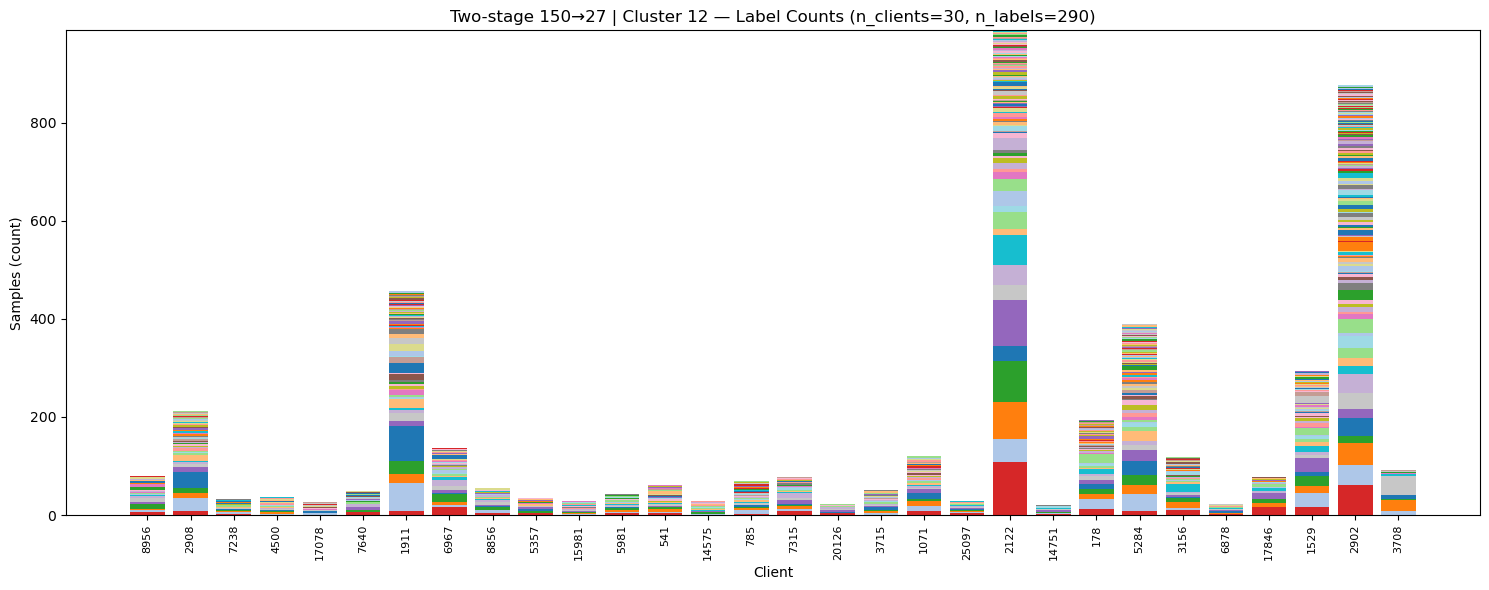

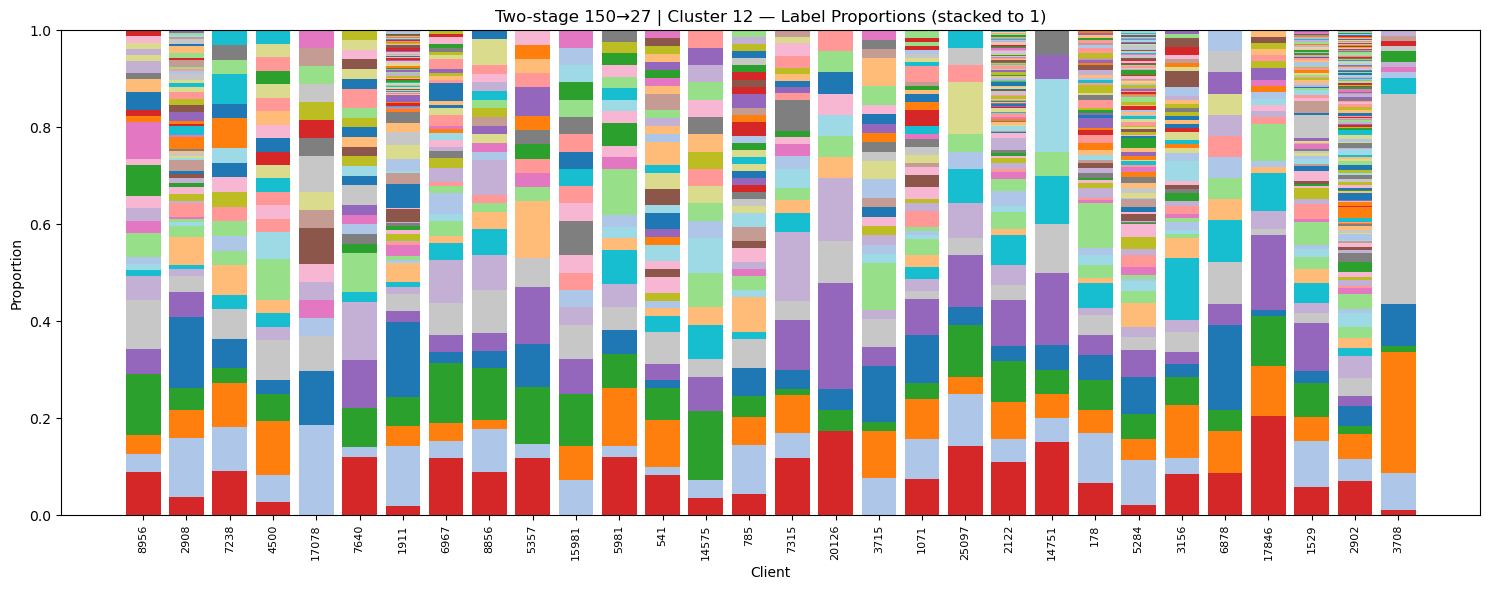

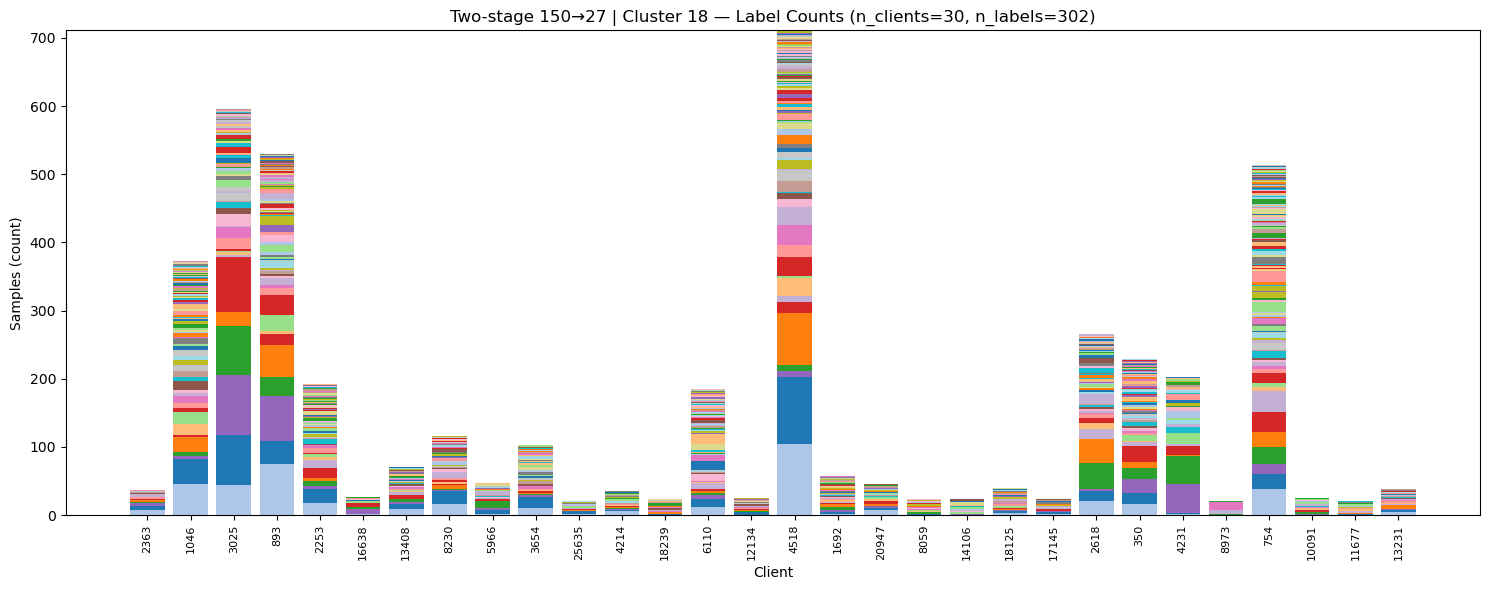

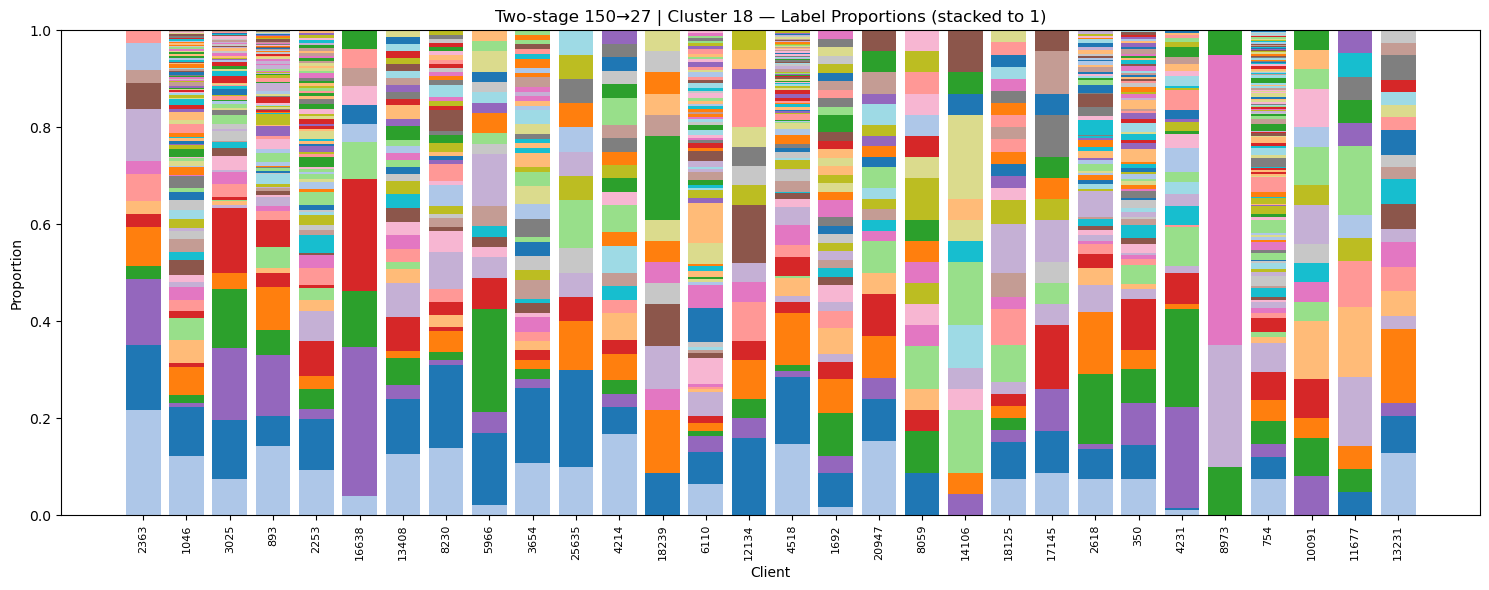

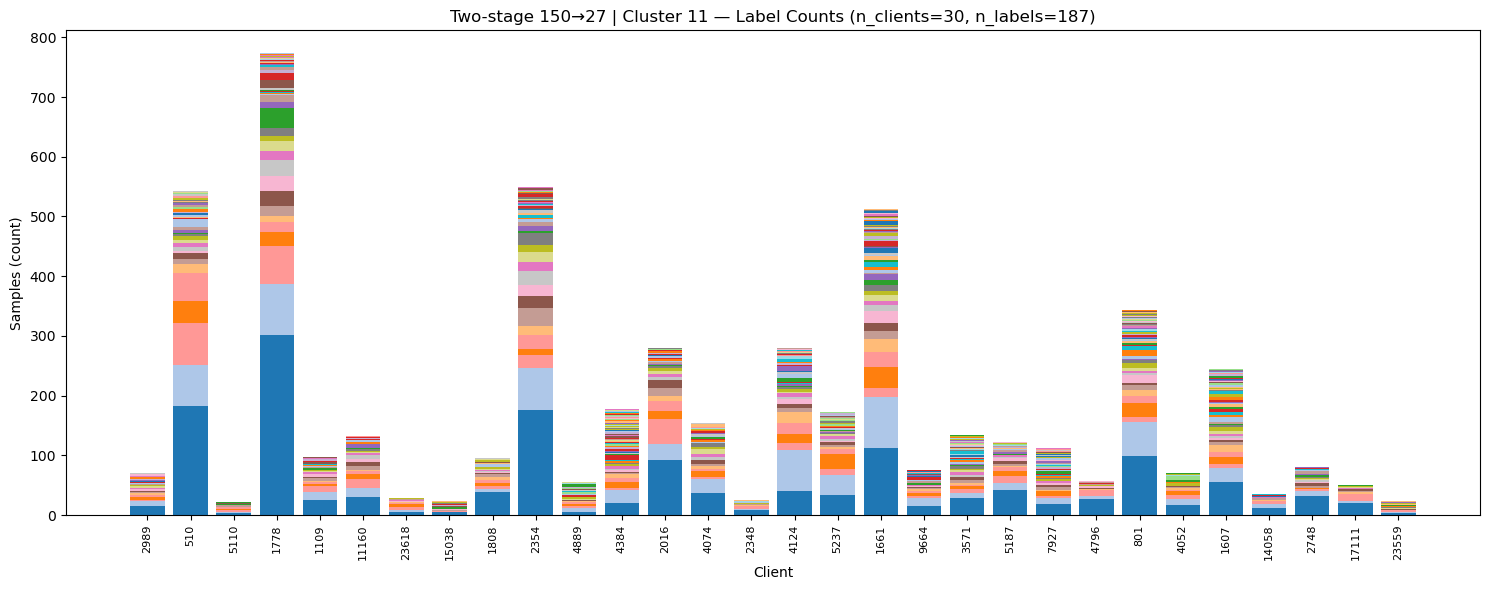

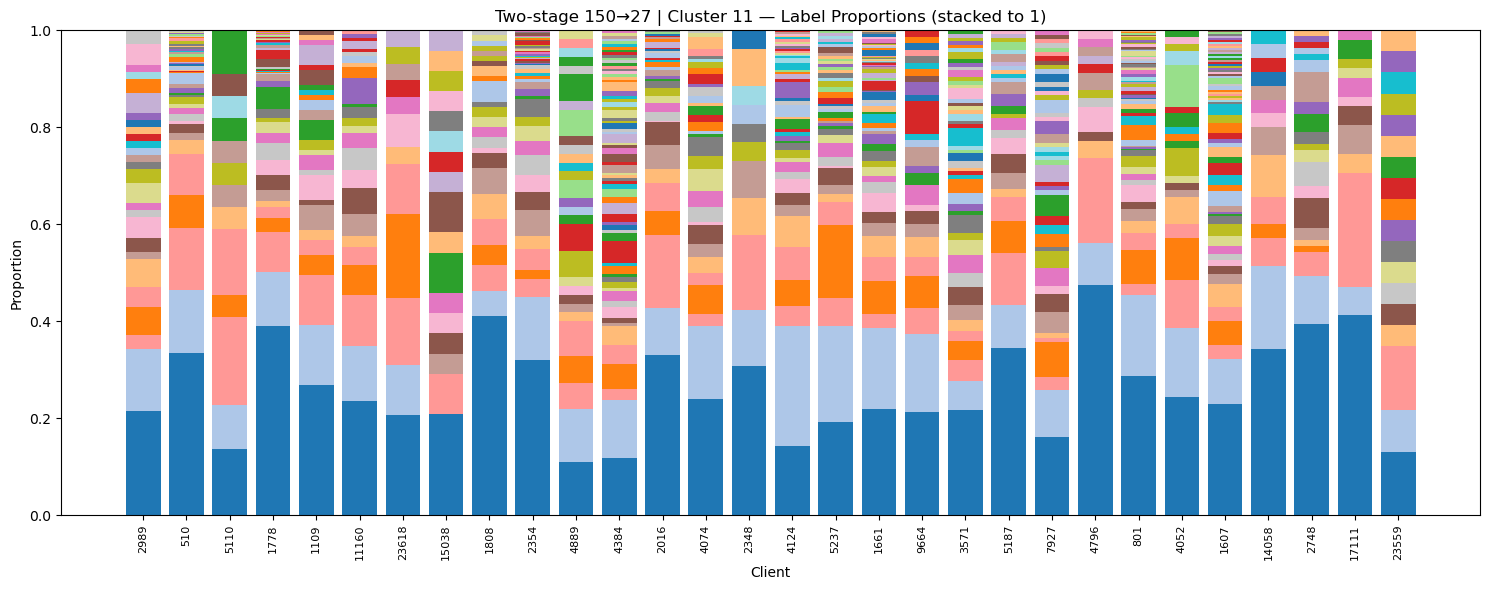

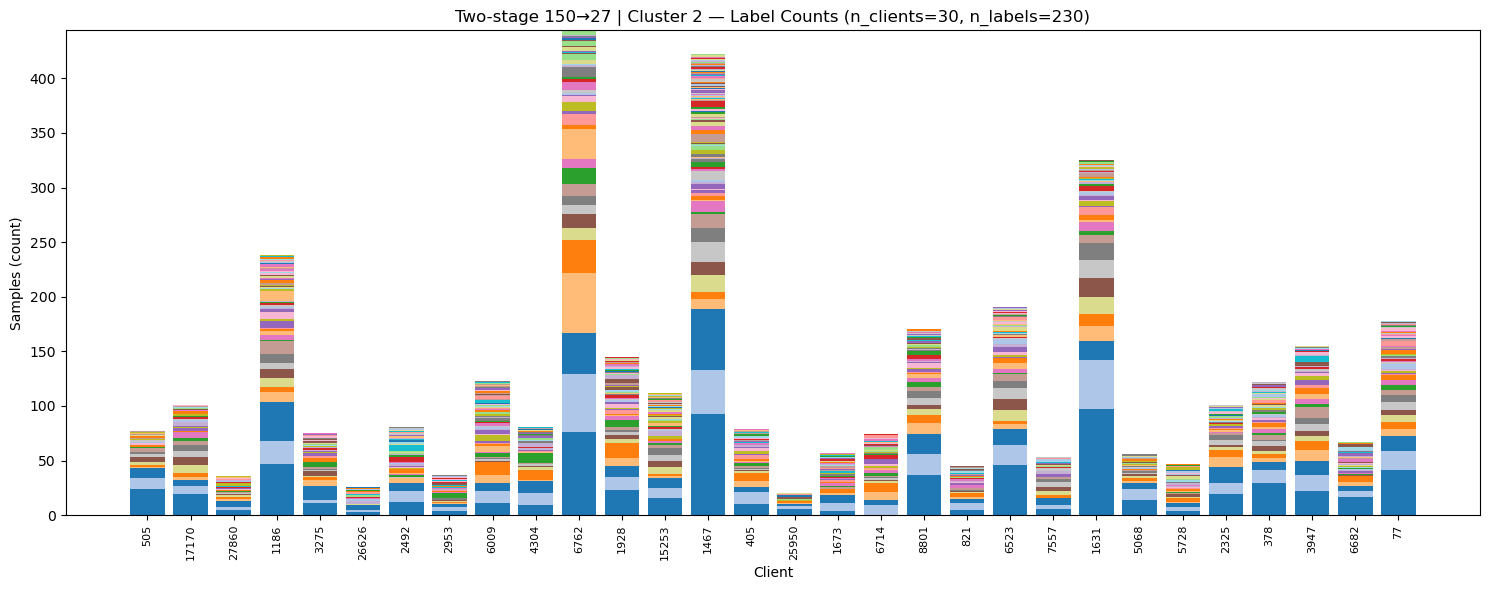

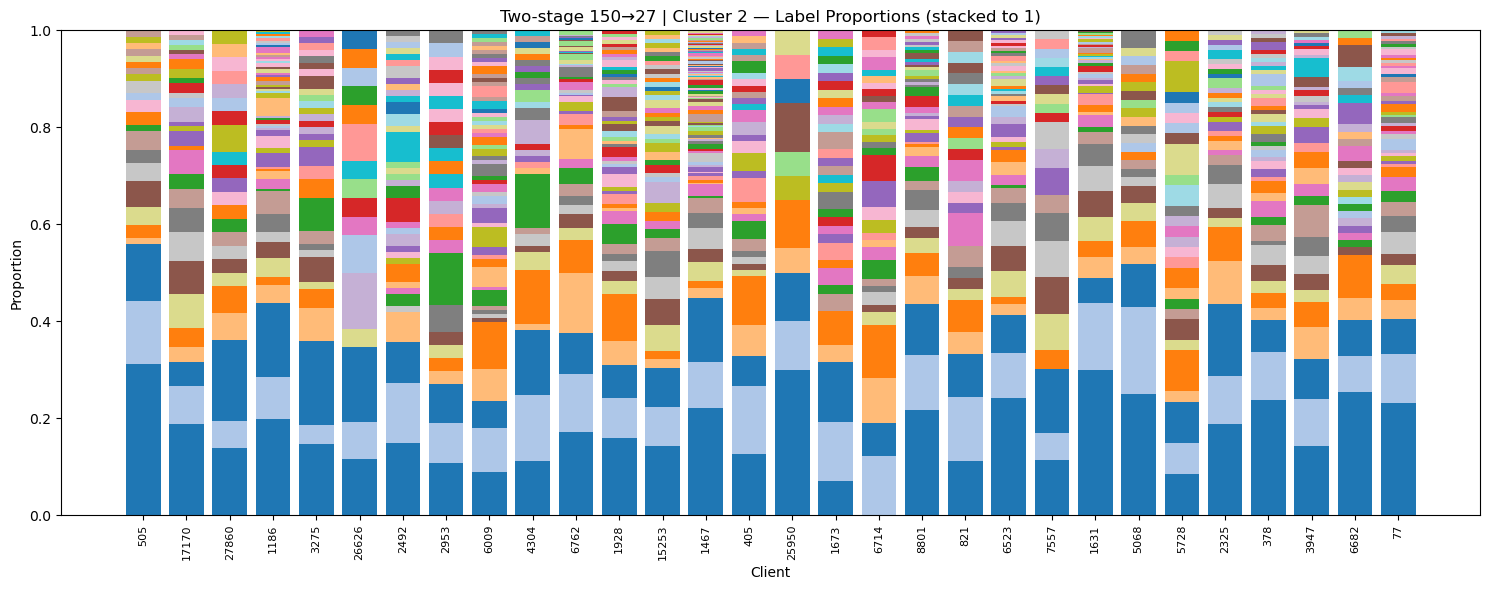

In [5]:
# --- Cell 5 (updated): Visualize label distributions with colors looping by label number ---
# Prereqs (already created in previous cells):
#   - X_counts: csr_matrix (n_clients x n_labels) of counts
#   - label_ids: np.array length n_labels (column id -> label_id)
#   - client_ids: list length n_clients (row id -> FedScale client_id)
#   - kmeans_labels: np.array length n_clients (direct k=27 clustering labels)
#   - macro_labels_client: np.array length n_clients (two-stage macro labels)

import numpy as np
import matplotlib.pyplot as plt

# ------------- Config -------------
RNG_SEED = 2025
N_CLUSTERS_TO_SHOW = 5
MAX_CLIENTS_PER_CLUSTER = 30
BAR_WIDTH = 0.8

rng = np.random.default_rng(RNG_SEED)

# ------------- Colors: loop by label number -------------
# Choose a discrete palette and repeat colors by label_id modulo palette size.
palette = plt.get_cmap('tab20')   # 20 distinct colors
PALETTE_SIZE = palette.N          # = 20
# Precompute mapping: label_id -> RGBA color
label_id_to_color = {int(lid): palette(int(lid) % PALETTE_SIZE) for lid in label_ids}

def _plot_stacked_bars_for_clients(
    client_row_indices,
    cluster_id,
    clustering_name,
    counts_matrix_csr,
    label_ids_global,
    bar_width=BAR_WIDTH
):
    """
    Draw two figures for the given client rows:
      (1) stacked counts per label,
      (2) stacked proportions per label (each bar sums to 1).
    Colors loop deterministically by label_id: palette[label_id % PALETTE_SIZE].
    """
    # Slice to a small dense submatrix: (#clients, n_labels)
    S = counts_matrix_csr[client_row_indices, :]
    S_dense = S.toarray().astype(float)

    # Keep only labels that appear in these clients
    col_sums = S_dense.sum(axis=0)
    used_mask = col_sums > 0
    if not np.any(used_mask):
        print(f"[{clustering_name} | cluster {cluster_id}] No labels in selection — skipping.")
        return

    S_used = S_dense[:, used_mask]                     # (#clients, L_used)
    used_label_indices = np.where(used_mask)[0]
    used_label_ids = label_ids_global[used_label_indices]

    # Order labels by total mass (descending) for clearer stacking
    order = np.argsort(col_sums[used_mask])[::-1]
    S_used = S_used[:, order]
    used_label_ids = used_label_ids[order]

    # Colors loop by label_id
    used_colors = np.array([label_id_to_color[int(lid)] for lid in used_label_ids], dtype=object)

    # X axis
    x = np.arange(S_used.shape[0])
    client_ids_sel = [client_ids[i] for i in client_row_indices]

    # ---------- Chart 1: Stacked counts ----------
    plt.figure(figsize=(max(10, S_used.shape[0] * 0.5), 6))
    bottom = np.zeros(S_used.shape[0], dtype=float)
    for l in range(S_used.shape[1]):
        heights = S_used[:, l]
        if np.allclose(heights, 0.0):
            continue
        plt.bar(x, heights, bottom=bottom, width=bar_width, color=used_colors[l], edgecolor='none')
        bottom += heights

    plt.title(f"{clustering_name} | Cluster {cluster_id} — Label Counts (n_clients={S_used.shape[0]}, n_labels={S_used.shape[1]})")
    plt.xlabel("Client")
    plt.ylabel("Samples (count)")
    plt.xticks(x, client_ids_sel, rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

    # ---------- Chart 2: Stacked proportions ----------
    row_sums = S_used.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0.0] = 1.0
    S_prop = S_used / row_sums

    plt.figure(figsize=(max(10, S_used.shape[0] * 0.5), 6))
    bottom = np.zeros(S_prop.shape[0], dtype=float)
    for l in range(S_prop.shape[1]):
        heights = S_prop[:, l]
        if np.allclose(heights, 0.0):
            continue
        plt.bar(x, heights, bottom=bottom, width=bar_width, color=used_colors[l], edgecolor='none')
        bottom += heights

    plt.title(f"{clustering_name} | Cluster {cluster_id} — Label Proportions (stacked to 1)")
    plt.xlabel("Client")
    plt.ylabel("Proportion")
    plt.ylim(0, 1.0)
    plt.xticks(x, client_ids_sel, rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()


# ------------- (A) Direct k=27 clustering -------------
unique_k = np.unique(kmeans_labels)
clusters_to_show_k = rng.choice(unique_k, size=min(N_CLUSTERS_TO_SHOW, len(unique_k)), replace=False)

for c in clusters_to_show_k:
    indices = np.where(kmeans_labels == c)[0]
    if len(indices) == 0:
        continue
    if len(indices) > MAX_CLIENTS_PER_CLUSTER:
        indices = rng.choice(indices, size=MAX_CLIENTS_PER_CLUSTER, replace=False)
    _plot_stacked_bars_for_clients(
        client_row_indices=indices.tolist(),
        cluster_id=int(c),
        clustering_name="Direct k=27",
        counts_matrix_csr=X_counts,
        label_ids_global=label_ids,
        bar_width=BAR_WIDTH
    )

# ------------- (B) Two-stage macro clustering (150 -> 27) -------------
unique_macro = np.unique(macro_labels_client)
clusters_to_show_macro = rng.choice(unique_macro, size=min(N_CLUSTERS_TO_SHOW, len(unique_macro)), replace=False)

for c in clusters_to_show_macro:
    indices = np.where(macro_labels_client == c)[0]
    if len(indices) == 0:
        continue
    if len(indices) > MAX_CLIENTS_PER_CLUSTER:
        indices = rng.choice(indices, size=MAX_CLIENTS_PER_CLUSTER, replace=False)
    _plot_stacked_bars_for_clients(
        client_row_indices=indices.tolist(),
        cluster_id=int(c),
        clustering_name="Two-stage 150→27",
        counts_matrix_csr=X_counts,
        label_ids_global=label_ids,
        bar_width=BAR_WIDTH
    )


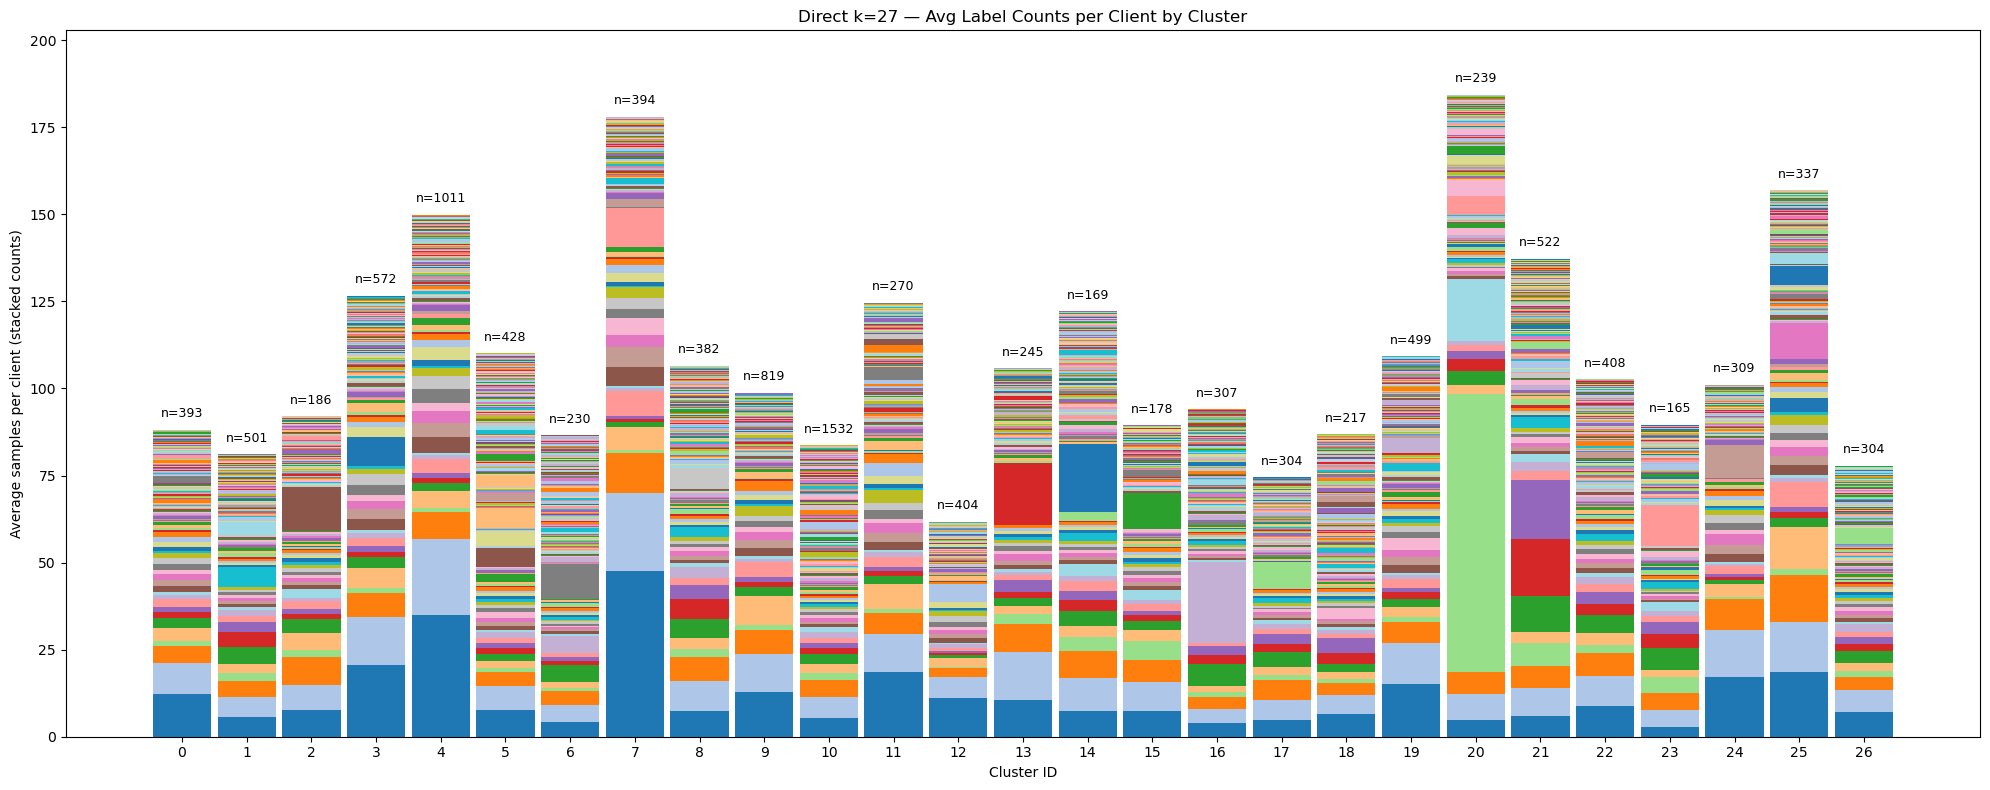

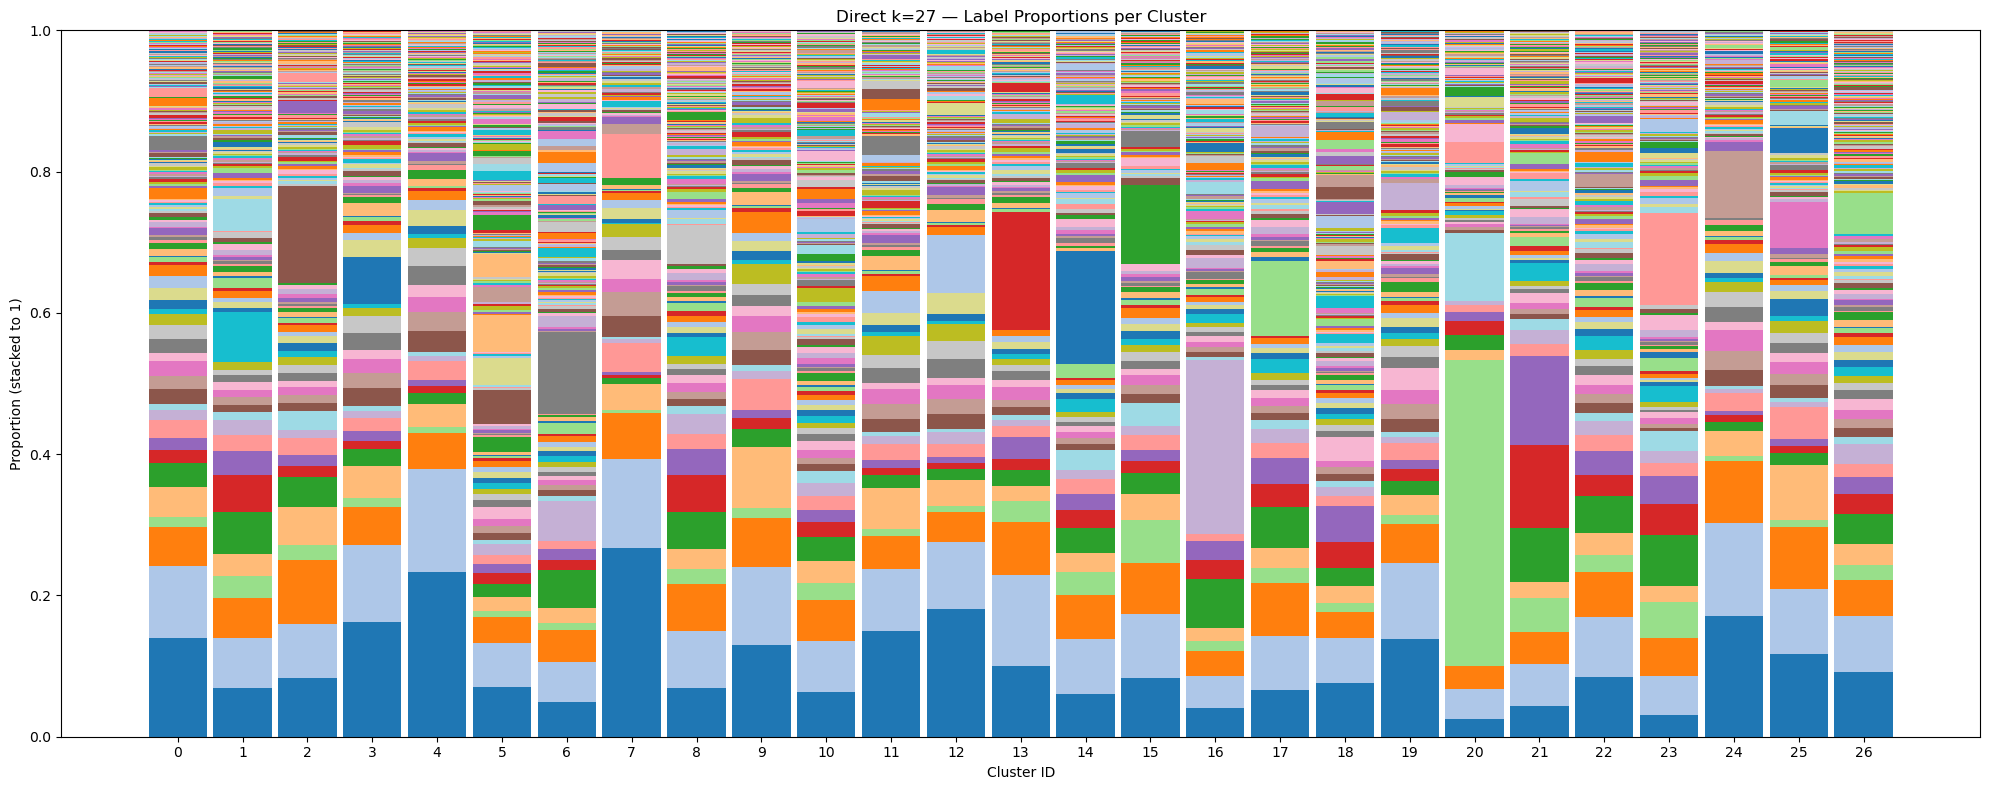

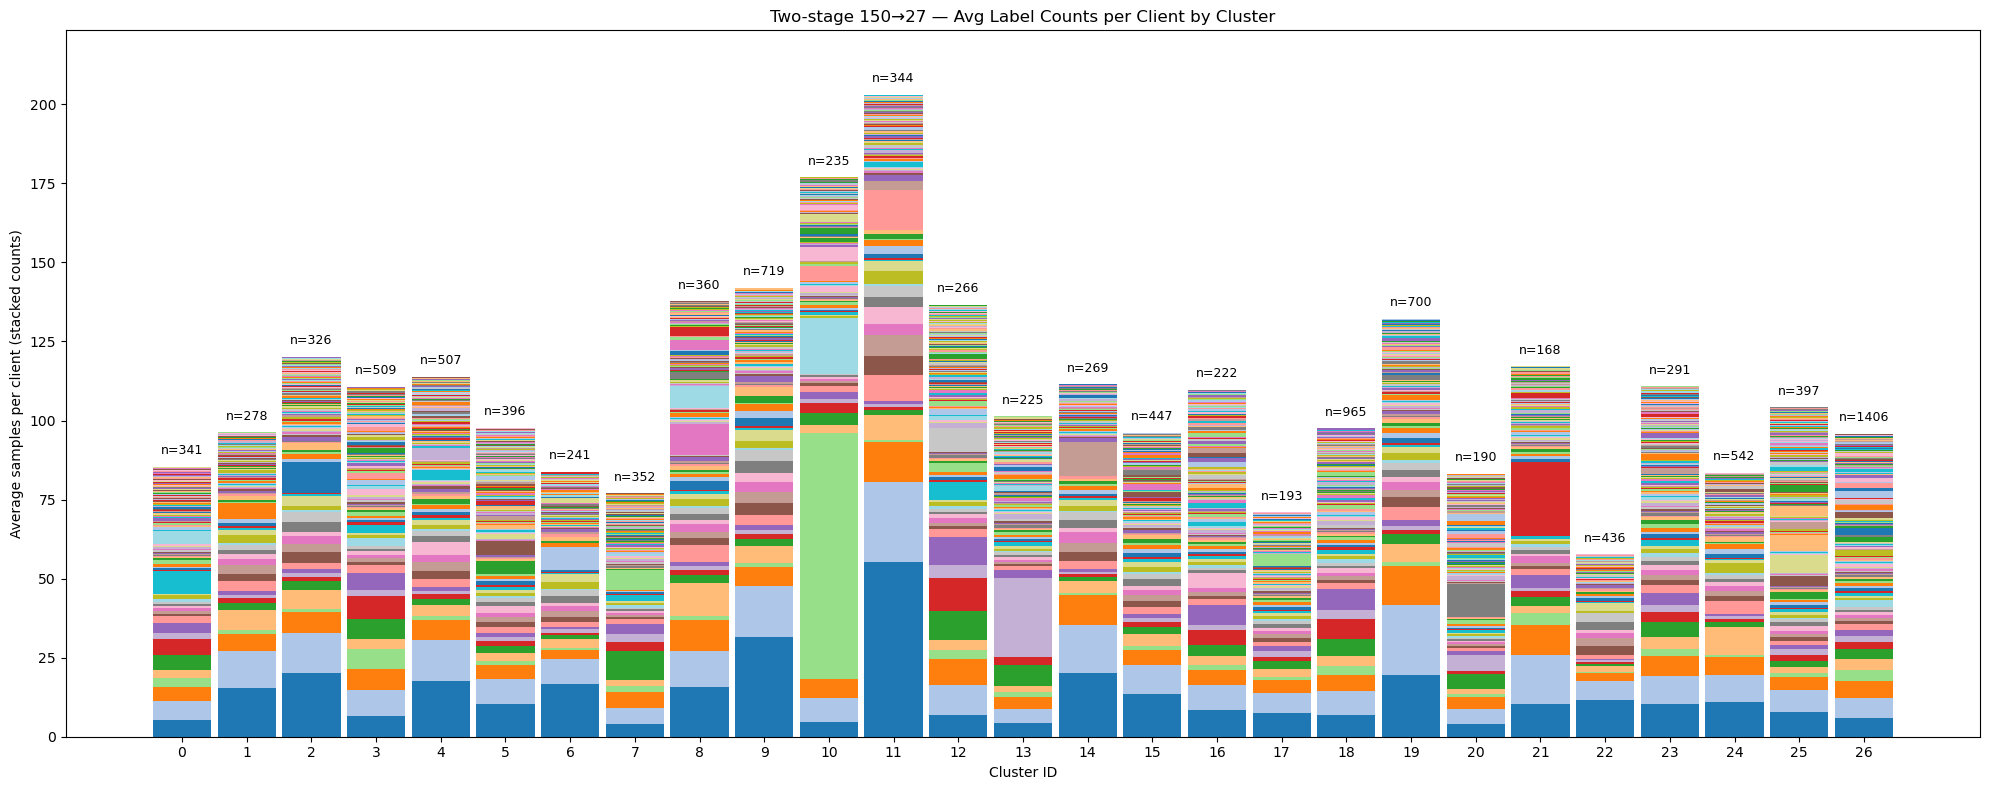

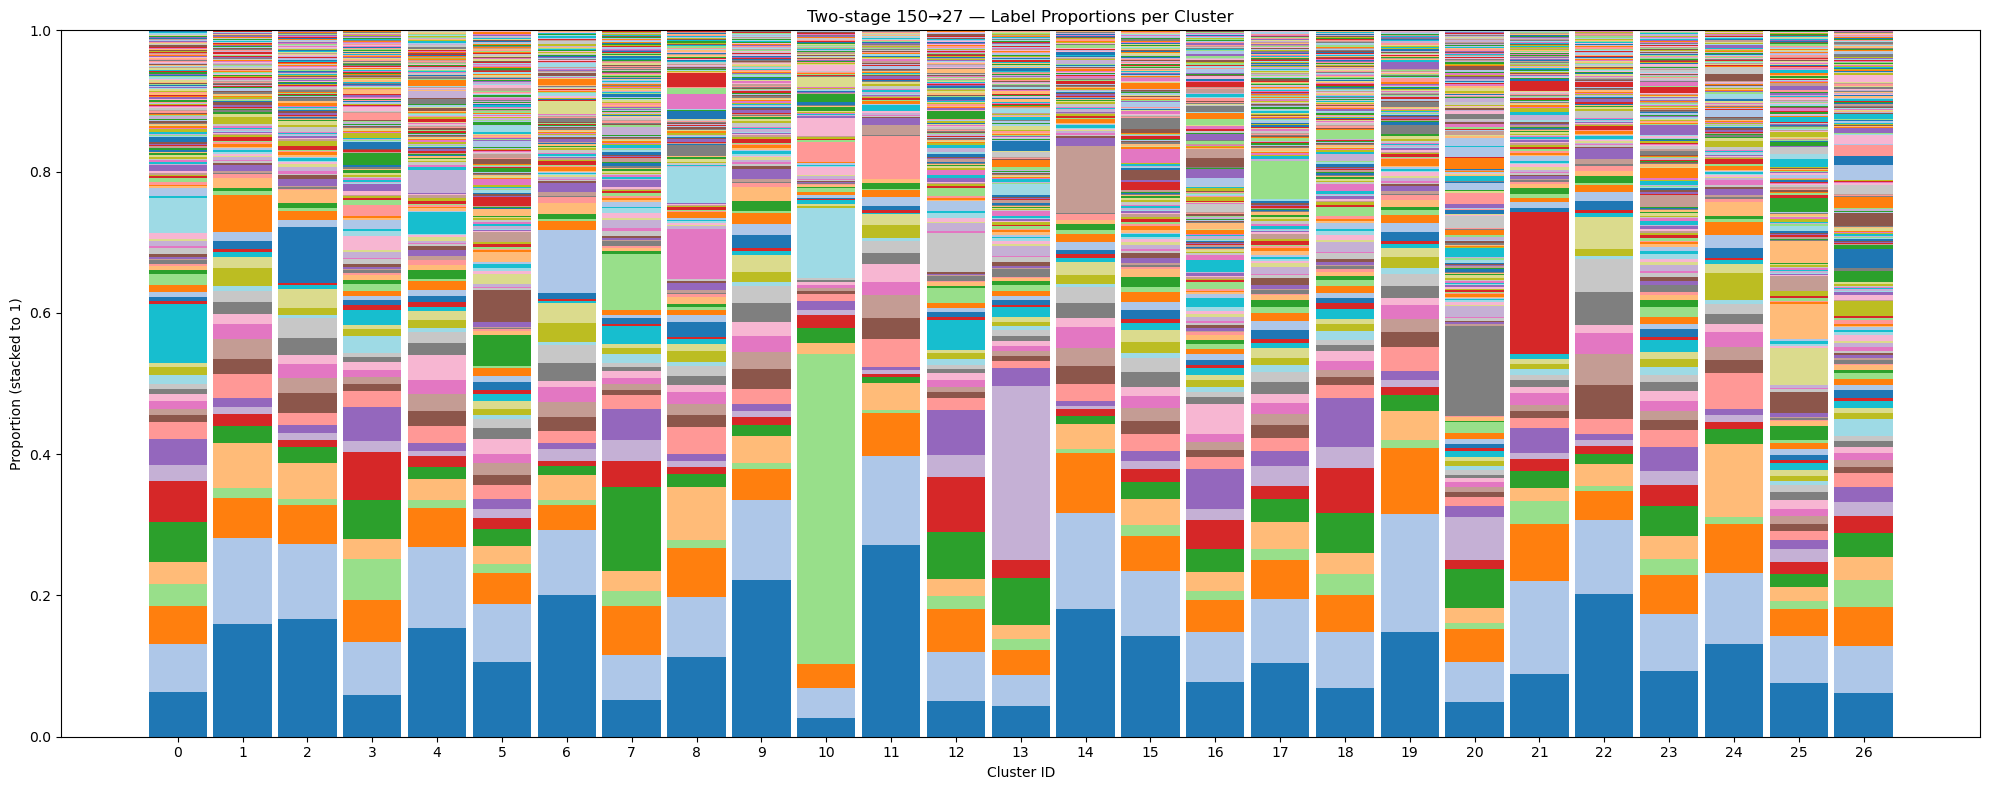

In [6]:
# --- Cell 6 (updated): Cluster-level stacked bar charts + client counts on non-normalized plot ---

import numpy as np
import matplotlib.pyplot as plt

# ----- Config -----
PALETTE = plt.get_cmap('tab20')   # 20-color discrete palette (colors loop by label_id)
PALETTE_SIZE = PALETTE.N
BAR_WIDTH = 0.9
FIG_W = 20
FIG_H = 8

# Colors loop by label number (consistent with earlier cells)
label_colors = np.array([PALETTE(int(lid) % PALETTE_SIZE) for lid in label_ids], dtype=object)

def compute_cluster_avg_counts(assignments, counts_csr):
    """
    For each cluster id in 'assignments', compute the average count per client for each label.
    Returns:
      cluster_ids: np.array of cluster ids (sorted)
      avg_counts:  (num_clusters x num_labels) array; each row sums to the average #samples/client in that cluster.
      cluster_sizes: np.array of number of clients per cluster (aligned with cluster_ids)
    """
    cluster_ids = np.unique(assignments)
    num_labels = counts_csr.shape[1]
    avg_counts = np.zeros((len(cluster_ids), num_labels), dtype=np.float64)
    cluster_sizes = np.zeros(len(cluster_ids), dtype=int)

    for i, c in enumerate(cluster_ids):
        idx = np.where(assignments == c)[0]
        cluster_sizes[i] = len(idx)
        if len(idx) == 0:
            continue
        summed = counts_csr[idx, :].sum(axis=0)
        summed = np.asarray(summed).ravel()
        avg_counts[i, :] = summed / float(len(idx))

    return cluster_ids, avg_counts, cluster_sizes

def plot_cluster_stacks(cluster_ids, avg_counts, cluster_sizes, title_prefix, normalize_rows=False):
    """
    Make a single stacked bar chart with one bar per cluster.
    - If normalize_rows=False: heights stack to the average #samples/client in that cluster,
      and we annotate the top of each bar with 'n=<cluster_size>'.
    - If normalize_rows=True: each bar is stacked to 1 (proportions).
    Labels are ordered by total mass across all clusters for readability.
    """
    # Filter out labels that never appear
    label_totals = avg_counts.sum(axis=0)
    used_mask = label_totals > 0
    if not np.any(used_mask):
        print(f"{title_prefix}: no labels with non-zero mass — nothing to plot.")
        return

    counts_used = avg_counts[:, used_mask]  # (C x L_used)
    used_label_indices = np.where(used_mask)[0]
    used_colors = label_colors[used_label_indices]

    # Order labels by global importance (descending)
    order = np.argsort(label_totals[used_mask])[::-1]
    counts_used = counts_used[:, order]
    used_colors = used_colors[order]

    # Normalize rows if requested (proportion stacks)
    if normalize_rows:
        row_sums = counts_used.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        to_plot = counts_used / row_sums
    else:
        to_plot = counts_used

    # Plot
    x = np.arange(len(cluster_ids))
    plt.figure(figsize=(FIG_W, FIG_H))
    bottom = np.zeros(len(cluster_ids), dtype=float)
    for l in range(to_plot.shape[1]):
        heights = to_plot[:, l]
        if np.allclose(heights, 0.0):
            continue
        plt.bar(x, heights, bottom=bottom, width=BAR_WIDTH, color=used_colors[l], edgecolor='none')
        bottom += heights

    if normalize_rows:
        plt.ylim(0.0, 1.0)
        plt.ylabel("Proportion (stacked to 1)")
        plt.title(f"{title_prefix} — Label Proportions per Cluster")
    else:
        # Annotate number of clients per cluster at the top of each bar
        bar_tops = bottom  # total height per bar
        # Add a little headroom so text isn’t clipped
        ymax = bar_tops.max() if bar_tops.size else 1.0
        plt.ylim(0.0, ymax * 1.10)
        for xi, top, n in zip(x, bar_tops, cluster_sizes):
            plt.text(xi, top + ymax * 0.015, f"n={int(n)}", ha="center", va="bottom", fontsize=9)
        plt.ylabel("Average samples per client (stacked counts)")
        plt.title(f"{title_prefix} — Avg Label Counts per Client by Cluster")

    plt.xlabel("Cluster ID")
    plt.xticks(x, [int(c) for c in cluster_ids], rotation=0)
    plt.tight_layout()
    plt.show()

# -------- Direct k=27 clustering --------
cluster_ids_k, avg_counts_k, sizes_k = compute_cluster_avg_counts(kmeans_labels, X_counts)
plot_cluster_stacks(cluster_ids_k, avg_counts_k, sizes_k, title_prefix="Direct k=27", normalize_rows=False)
plot_cluster_stacks(cluster_ids_k, avg_counts_k, sizes_k, title_prefix="Direct k=27", normalize_rows=True)

# -------- Two-stage 150→27 clustering --------
cluster_ids_m, avg_counts_m, sizes_m = compute_cluster_avg_counts(macro_labels_client, X_counts)
plot_cluster_stacks(cluster_ids_m, avg_counts_m, sizes_m, title_prefix="Two-stage 150→27", normalize_rows=False)
plot_cluster_stacks(cluster_ids_m, avg_counts_m, sizes_m, title_prefix="Two-stage 150→27", normalize_rows=True)


In [7]:
# --- Cell 7: Count device clients by rank (from clients.pkl) ---

import pandas as pd

# Assumes `devices_df` with columns ['device_id', 'model', 'rank'] is available from Cell 1

RANK_MIN, RANK_MAX = 1, 27
rank_index = pd.Index(range(RANK_MIN, RANK_MAX + 1), name="rank")

# Count ranked devices per rank (1..27), fill missing ranks with 0
rank_counts = (
    devices_df["rank"]
    .dropna()
    .astype(int)
    .value_counts(sort=False)
    .reindex(rank_index, fill_value=0)
    .rename("num_clients")
)

num_unranked = int(devices_df["rank"].isna().sum())
total_devices = int(len(devices_df))

print("=== Clients per rank (from clients.pkl) ===")
print(f"Total device clients: {total_devices:,}")
print(f"Unranked (model not found in clusters.json): {num_unranked:,}\n")

print(rank_counts.reset_index().to_string(index=False))

# (Optional) also expose a Series for later use:
clients_per_rank = rank_counts  # pd.Series indexed by rank 1..27


=== Clients per rank (from clients.pkl) ===
Total device clients: 12,641
Unranked (model not found in clusters.json): 0

 rank  num_clients
    1           91
    2          671
    3          834
    4          108
    5          301
    6         1082
    7          485
    8          216
    9         2018
   10          841
   11            9
   12           62
   13           37
   14         1326
   15           48
   16         1790
   17          404
   18          538
   19           16
   20           29
   21          863
   22          763
   23           10
   24           71
   25           17
   26           10
   27            1
